# **LM fine-tuning using Lora and MTL-Lora for a medical chatbot**
This project aims to develop a medical assistant by fine-tuning the LLaMA 1b model (1 billion parameters).

The project is divided into two main phases:

## **Phase 1: Fine-Tuning with PubMedQA Dataset**
We will fine-tune the LLaMA model using the **PubMedQA dataset**, which includes medical questions, context and answers. This phase focuses on enhancing the model's lexicon and semantic understanding in the medical domain. The results of two fine-tuning techniques will be compared:

1. **LoRA (Low-Rank Adaptation):**
   - LoRA adds low-rank adaptation matrices to the frozen weights of the model.
   - This technique enables efficient fine-tuning by training only a few additional parameters.

2. **Traditional Fine-Tuning:**
   - All layers of the model are frozen except for the final head.
   - Gradients are allowed to flow only through the last layer during training.

### **Evaluation**
The performance of the three configurations (1) base model, (2) LoRA-tuned model, and (3) traditionally fine-tuned model—will be compared. Evaluation metrics will include:
- **Perplexity**
- **BLEU Score**
- **ROUGE Score**

Additionally, chatbot outputs generated by the three models will be compared to assess qualitative differences.

## **Phase 2: Exploring Multi-Task LoRA**
In this phase, we will explore **advanced LoRA techniques** to enable the model to perform multiple tasks learned through a single fine-tuning process.

### **Approach**
We aim to implement and test a theoretical LoRA framework introduced in October 2024 ([reference link](https://arxiv.org/abs/2410.09437)). This framework proposes leveraging LoRA's adaptation capabilities for multi-task learning.

The goal is to train the model efficiently on various tasks simultaneously while maintaining high performance across all tasks.

---






# **Dependencies**
* Install all the necessary dependencies for the correct execution of the subsequent code blocks.  
* Import the required libraries.  
* Declare the main global variables.  





In [ ]:
!pip install transformers accelerate datasets peft
!pip install -U bitsandbytes
!pip install evaluate
!pip install rouge_score
!pip install nltk
!pip install sentencepiece

from google.colab import drive
import torch
from datasets import load_dataset
from datasets import DatasetDict
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, TrainingArguments, Trainer, DataCollatorForSeq2Seq
from peft import LoraConfig, get_peft_model
import bitsandbytes as bnb
import math
import evaluate
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import softmax
import os


# Configurations
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
metrics = {}
ds = load_dataset("qiaojin/PubMedQA", "pqa_unlabeled")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00
  P

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.19k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/66.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/61249 [00:00<?, ? examples/s]

# **Import Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Text Preprocessing for Fine-Tuning with Medical Dataset**

In this step, we preprocess the medical dataset so that the model can predict the next token based on an input that combines the **question**, **context**, and **answer**. This approach allows the model to train on medical terminology and learn the relationships between these elements.

## Concatenating Question, Context, and Answer

The model input consists of the **question**, **context**, and **answer** concatenated together, enabling the model to predict the next token in a medical context. The formatted input is as follows:

- `Question: {question}`
- `Context: {context}`
- `Answer: {answer}`

This method helps the model learn medical terminology, improving its ability to understand and generate responses that are consistent with the medical context.

## Dataset Reduction for Time Efficiency

For **time efficiency**, we had to reduce the size of our dataset. Using the full dataset would have resulted in excessive training times, especially when applying traditional fine-tuning methods.

Thus, we applied a **subset** of the dataset, ensuring it still contains a diverse range of examples to support effective training.

## Dataset Splitting

Finally, the dataset was split into three main subsets:

1. **Train**: The training set, containing 70% of the data, used for model training.
2. **Test**: The test set, used for evaluating the model's final performance.
3. **Validation**: The validation set, used during training to monitor overfitting and ensure proper generalization.

This division allows for efficient training, validation, and testing, ensuring the fine-tuning process is conducted on meaningful data without compromising training time.


In [ ]:
def preprocess_data(example):
    question = example['question']
    context = example['context']
    long_answer = example['long_answer']
    # Combine data into a consistent format
    input_text = f"Question: {question}\nContext: {context}\nAnswer: {long_answer}"
    return {"input_text": input_text}

# 2. Preprocessing: remove incomplete records
def preprocess_test(example):
    question = example['question']
    context = example['context']
    long_answer = example['long_answer']
    input_text = f"Question: {question}\nContext: {context}"
    output_text = f"Answer: {long_answer}"
    return {"input_text": input_text, "long_answer": output_text}

# Apply the subset to the single 'train' split
train_size = 8000
test_size = 2000
validation_size = 500

# Shuffle the data to obtain a random distribution
ds = ds["train"].shuffle(seed=42)

# Split the data
train_ds = ds.select(range(train_size))
test_ds = ds.select(range(train_size, train_size + test_size))
validation_ds = ds.select(range(train_size + test_size, train_size + test_size + validation_size))

train_ds = train_ds.map(preprocess_data, remove_columns=ds.column_names)
test_ds = test_ds.map(preprocess_test, remove_columns=ds.column_names)
validation_ds = validation_ds.map(preprocess_test, remove_columns=ds.column_names)

# Create a new DatasetDict
split_ds = DatasetDict({
    "train": train_ds,
    "test": test_ds,
    "validation": validation_ds,
})


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

# **LoRA Fine Tuning**
# Extraction of the Reference Model LLama 3.2 1B

In [ ]:
#model name
model_name = "meta-llama/Llama-3.2-1B"

# loading of the model and the dataset
original_model=AutoModelForCausalLM.from_pretrained(model_name,token="YOUR_TOKEN").to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(model_name, token="YOUR_TOKEN")
tokenizer.pad_token = tokenizer.eos_token  # setting of pad and eos token


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]


# Model Loading and Fine-Tuning with LoRA

In this section, we load the **LLama 3.2 1B** model and fine-tune it using the **LoRA** technique to adapt it for our specific medical dataset. Below is a brief breakdown of each step:

### 1. **Model Loading**
We load the pre-trained model using `AutoModelForCausalLM`, applying automatic device mapping for GPU utilization and using **FP16** for efficiency. The model is then moved to the specified device (`DEVICE`).

### 2. **LoRA Configuration**
The **Low-Rank Adaptation (LoRA)** technique is configured with the following parameters:
- **r=8**: Number of LoRA parameters.
- **lora_alpha=32**: Scaling factor.
- **lora_dropout=0.1**: Dropout probability for LoRA layers.

This allows us to efficiently adapt the model to the medical domain while using fewer resources compared to traditional fine-tuning.

### 3. **Applying LoRA**
We apply LoRA to the model using the `get_peft_model` function, modifying the original model's weights for the specific task.

### 4. **Data Tokenization**
We preprocess and tokenize the dataset to ensure the model receives the appropriate input format for training.

### 5. **Training Setup**
The training is configured using `TrainingArguments`, including the batch size, number of epochs, learning rate, and checkpoint settings. The `Trainer` class is then used to handle the training and evaluation.

## How LoRA Works

**LoRA (Low-Rank Adaptation)** is a technique for efficiently fine-tuning large pre-trained models by introducing low-rank matrices to adapt the model's parameters. This approach drastically reduces the number of parameters that need to be trained, leading to faster training times and lower resource usage.









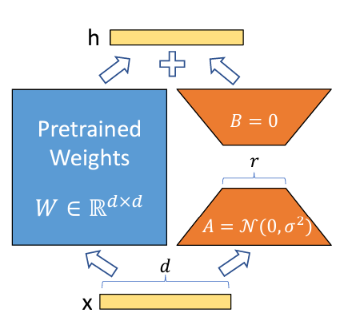

### LoRA Maths:

In standard fine-tuning, the model updates the weight matrix **W**. In LoRA, this is adapted using low-rank matrices **A** and **B** as follows:
$$
W' = W + \Delta W = W + A \cdot B
$$


Where:
- **W** is the original weight matrix.
- **A** and **B** are low-rank matrices that are learned during training.
- **$\Delta W$** is the additional update to the weight matrix.

This method allows for significant parameter savings while still achieving high performance on downstream tasks, making it ideal for large-scale models with limited computational resources.


In [ ]:
# Load the model
model_lora = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,  # Use FP16 for efficiency instead FP32
    token="YOUR_TOKEN"
).to(DEVICE)

# LoRA configuration
lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    inference_mode=False,
    r=8,  # Number of LoRA parameters
    lora_alpha=32,  # Scaling coefficient
    lora_dropout=0.1  # Dropout probability for LoRA
)

# Apply LoRA to the model
model_lora = get_peft_model(original_model, lora_config)

# Tokenization function
def tokenize_data(example):
    return tokenizer(
        example["input_text"],
        truncation=True,
        max_length=512,
        padding="max_length"
    )

# Preprocessing and tokenization
tokenized_ds = split_ds.map(tokenize_data, batched=True)

# Data Collator for causal language modeling
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# Configuration of training arguments
training_args = TrainingArguments(
    output_dir="./lora_pubmedqa",
    per_device_train_batch_size=4,  # Batch size for training
    per_device_eval_batch_size=4,
    num_train_epochs=3,  # Number of epochs
    learning_rate=5e-4,  # Learning rate
    logging_steps=10,  # Logging frequency
    evaluation_strategy="steps",  # Evaluation strategy
    eval_steps=2000,  # Evaluation frequency
    save_steps=2000,
    save_total_limit=2,
    fp16=True,
    bf16=False,
    optim="adamw_hf",  # Standard optimizer
    push_to_hub=False
)

# Trainer
trainer = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-26b056dca8ef>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


**We start the training and calculate the perplexity for the test set**

In [ ]:
# Start of training with LoRA
print("Inizio del training con LoRA...")
trainer.train()

In [ ]:
# Final evaluation
print("Final evaluation...")
eval_results = trainer.evaluate(tokenized_ds["test"])

# Extract the loss from the evaluation
loss = eval_results["eval_loss"]

# Calculate perplexity
perplexity = math.exp(loss)

# Print perplexity
print(f"Perplexity: {perplexity}")

# Save the perplexity of this model in metrics
metrics["perplexity"] = perplexity


Valutazione finale...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Perplexity: 7.149148171103074


**Saving of the model on drive**



In [ ]:
#Save the fine-tuned model
model_lora.save_pretrained("/content/drive/Shareddrives/Multimedia /LLM/Project/Models/lora_pubmedqa_model")  # Salva il modello fine-tunato
tokenizer.save_pretrained("/content/drive/Shareddrives/Multimedia /LLM/Project/Models/lora_pubmedqa_model")  # Salva il tokenizer associato

print("Modello e tokenizer salvati con successo!")



# **Fine-Tuning the Model with Layer Freezing**

In this approach, we use the pre-trained model as a **feature extractor** by freezing all layers except for the last one, where we perform traditional training. The layer that remains unfrozen is called **norm.weight**, which is the last header of the LLama model.

By freezing the earlier layers, the model retains the learned features from pre-training while only adjusting the parameters in the final layer, which helps optimize the model for the specific task at hand with minimal computational cost.

In [ ]:
# Load the model
model_freezing = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    token="YOUR_TOKEN"
).to(DEVICE)

# Freeze all layers except the last one
for name, param in model_freezing.named_parameters():
    if "norm.weight" not in name:  # Keep only the last layer unfrozen
        param.requires_grad = False

# Tokenization function
def tokenize_data(example):
    return tokenizer(
        example["input_text"],
        truncation=True,
        max_length=512,
        padding="max_length"
    )

# Preprocessing and tokenization
tokenized_ds = split_ds.map(tokenize_data, batched=True)

# Data Collator for causal language modeling
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# Configuration of training arguments
training_args = TrainingArguments(
    output_dir="./traditional_finetune_pubmedqa",
    per_device_train_batch_size=4,  # Batch size for training
    per_device_eval_batch_size=4,
    num_train_epochs=3,  # Number of epochs
    learning_rate=5e-4,  # Learning rate
    logging_steps=10,  # Logging frequency
    evaluation_strategy="steps",  # Evaluation strategy
    eval_steps=2000,  # Evaluation frequency
    save_steps=2000,
    save_total_limit=2,
    fp16=False,
    bf16=False,
    optim="adamw_hf",  # Standard optimizer
    push_to_hub=False
)

# Trainer
trainer = Trainer(
    model=model_freezing,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-e7f4e5d5e04d>:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


**test and calculation of the perplexity**

In [ ]:
# Start training
print("Starting traditional fine-tuning...")
trainer.train()

In [ ]:
# Final evaluation
print("Final evaluation...")
eval_results = trainer.evaluate(tokenized_ds["test"])

# Extract the loss from the evaluation
loss = eval_results["eval_loss"]

# Calculate perplexity
perplexity = math.exp(loss)

# Print perplexity
print(f"Perplexity: {perplexity}")

# Save the perplexity of this model in metrics
metrics["perplexity"] = perplexity

**Saving of the model on drive**

In [ ]:
# saving the fine-tuned model
model_freezing.save_pretrained("/content/drive/Shareddrives/Multimedia /LLM/Project/Models/traditional_finetune_pubmedqa_model")
tokenizer.save_pretrained("/content/drive/Shareddrives/Multimedia /LLM/Project/Models/traditional_finetune_pubmedqa_model")

print("Modello e tokenizer salvati con successo!")

# **Loading of the models from Google Drive**
In order to speed up the presentation the previous models have already been fine tuned and saved on drive, now they will loaded to show the results obtained

In [ ]:
import torch
import gc

torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

130

In [ ]:
# Carica il modello e il tokenizer del modello con lora
model_path = "/content/drive/Shareddrives/Consegna_Progetti_MIRCV/LM/Models/lora_pubmedqa_model"  # Sostituisci con il percorso corretto
model_lora = AutoModelForCausalLM.from_pretrained(model_path , token="YOUR_TOKEN" ).to(DEVICE)
tokenizer_lora = AutoTokenizer.from_pretrained(model_path, token="YOUR_TOKEN")
# Carica il modello e il tokenizer del modello con freezing
model_path = "/content/drive/Shareddrives/Consegna_Progetti_MIRCV/LM/Models/traditional_finetune_pubmedqa_model"  # Sostituisci con il percorso corretto
model_freezing = AutoModelForCausalLM.from_pretrained(model_path, token="YOUR_TOKEN").to(DEVICE)
tokenizer_freezing = AutoTokenizer.from_pretrained(model_path, token="YOUR_TOKEN")
tokenizer_original = AutoTokenizer.from_pretrained(model_name, token="YOUR_TOKEN")
#inserimento dei token in una lista di token chiamata tokenizers
tokenizers = {
    "original": tokenizer_original,
    "freezing": tokenizer_freezing,
    "lora": tokenizer_lora
}

models = {
    "original": original_model,
    "freezing": model_freezing,
    "lora": model_lora
}

for tokenizer in tokenizers.values():
    tokenizer.pad_token = tokenizer.eos_token
for model in models.values():
    if model.config.pad_token_id is None:
        model.config.pad_token_id = tokenizer.pad_token_id

# **Some Prompt Examples**
how does the model reply to some of the question inside the dataset?
how do the other model behave also?

In [ ]:
# Function to generate responses for the first questions
def generate_responses_for_train(train_ds, models, tokenizers, input_field='input_text', max_length=256, num_questions=10):
    print("Testing response generation using questions taken from the test set:\n")
    for i in range(min(num_questions, len(train_ds))):
        question = ds["question"][i]
        # Print the question
        print(f"\nQuestion {i + 1}: {question}")

        # Generate responses for each model
        for model_name, model in models.items():
            tokenizer = tokenizers[model_name]
            input = tokenizer(question, return_tensors="pt", truncation=True, padding=True, max_length=max_length).to(DEVICE)
            # Generate the response
            with torch.no_grad():
                output = model.generate(
                    input.input_ids,
                    max_length=512,
                    num_return_sequences=1,
                    do_sample=True,
                    top_k=50,
                    top_p=0.95,
                    temperature=0.7,
                    no_repeat_ngram_size=2,
                    attention_mask=(input.input_ids != tokenizer.pad_token_id),
                    pad_token_id=tokenizer.pad_token_id
                )
                response = tokenizer.decode(output[0], skip_special_tokens=True)

            # Print the response
            print(f"Response from '{model_name}': {response}")

# Call the function
generate_responses_for_train(train_ds, models, tokenizers)




```
Test sulla generazione utilizzando domande prelevate dal test set:


Domanda 1: Unipolar mania: a distinct entity or characteristic of manic preponderance?

Risposta da 'original': Unipolar mania: a distinct entity or characteristic of manic preponderance? A review
Aims: To review the literature on unipolarity, a characteristic feature of manias. Method: We searched the Medline database, PsychInfo and Cochrane for English language articles published between 1946 and 2000. Results: There were 10 papers published on 8 different patients. Only 4 of these had been treated with lithium or valproate. The remaining six were untreated. All 6 had a history of bipolar disorder. Three had suffered from depression. Four of the patients had had 1-4 previous manic episodes. Most had not been admitted to hospital. Two patients were admitted with psychosis. There was a marked male predominance. Conclusions: The prevalence of unipoles is unknown. It is unlikely that they are a common subgroup of patients with bipolar I disorder and therefore it is important that the term 'unipole' is avoided.
Dive into the research topics of 'Unopolar Mania'. Aims To Review the Literature on Unipolare Manie: A Review'. Together they form a unique fingerprint.
McGuffin, P., & Gourlay, S. (2001). Unopalar manie : a distinctive entity? Journal of Psychiatric and Mental Health Nursing, 9 (4), 299-303. https://doi.org/10.1046/j.1365-2850.x.2002.00589.x
McGruff, Patricia ; Goulay, Stephen. / Unolopar mani : A distinctive enity?. In: Journal Of Psychiartic And Mental Halth Nursing. 1997 ; Vol. 13, No.4. pp.299 - 303.
abstract = "Aim:To review literature of on uoplar maniae. Methods:We searched Medliine database Psychinfo and Cochran for Englishe language article published betwen 1906 -20002000. Result:There were10papers published 86 different patient. Only 44 had btted treated witli lithium o r valprate.The remianing six w ere unttreated. Allof them had histrory of bi polar disorder.Three had sufferred from depresion.Four of them hadd 110 previous maniac episodes.Most had oot been in hospital Two were admitted with psychosis.There was mado male predom

Risposta da 'freezing': Unipolar mania: a distinct entity or characteristic of manic preponderance? A case-control study of 1,500 patients with bipolar disorder
G. B. P. Knapp, F. J. R. A. Goodwin, D. M. C. Dudgeon, A.-M. S. McIntosh, C.-H. H. Chang, K. L. Leung, W.-K. Tsai, P.-J. Y. Lee, S.-C. Lin, J.-S. Chen, H.-W. Wang, Y.-L. Liu, M.-Y. Kuo, T.-F. Huang, L.-T. Shen, G. W. Lau, I. T. Chan, V. Cheng, N. Fung
Background: The clinical features of unipolarity (BP) have been described, but its prevalence and the clinical significance of the subtype have not been determined. Methods: We performed a case-controlled study in the 3-year follow-up of a population-based cohort of patients recruited from the National Health Insurance Research Database. We compared 250 patients who met the DSM-IV criteria for bipolar I disorder with 750 patients meeting the criteria of BP. Results: BP was associated with a higher lifetime prevalence of alcohol abuse and dependence (P <.001) and with an increased risk of suicide attempts (odds ratio [OR] = 2.17; P =.02). Although BP patients did not differ from controls in terms of age at onset of illness, duration of course, or duration on mood stabilizers, BP subjects were more likely to have experienced one or more mood episodes per year in their lifetime (OR =2, 95% confidence interval [CI] 0.79-5.53; 8.1% vs. 6.4%; P <.03) or to use mood-stabilizing medication more frequently (26.2% v 18.7%; 26% and 20%; respectively; both P's < 001). BP had a stronger association with suicide (12.3% versus 4.9%; OR =1.82; CI =0-2; log-rank test, <0). The most frequent mood episode type was hypomania (67.6% in BP, compared with hypomania in 51.5% of controls, and manic episodes in both groups were rare). Conclusions: These results indicate that the prevalence,

Risposta da 'lora': Unipolar mania: a distinct entity or characteristic of manic preponderance? A population-based study in 13 countries
Manic preoccupation is a defining feature of bipolar disorder. However, it remains unclear whether manic symptoms are an exclusive characteristic or a feature common to all bipolar patients. We examined whether the presence of unipolarity in the manic episode is associated with a distinctive pattern of symptoms or whether unipo-lar manics are simply a subgroup of patients with bipolar I or II disorder who are characterized by a greater tendency to exhibit manic features in their mood episodes. A total of 15 508 patients who fulfilled DSM-IV criteria for bipolar II or I disorder were included in this study. Unipolars were defined as patients without comorbid major depressive disorder (MDD) or dysthymic disorder in a manic mood episode. The results showed that 14.9% of the patients were unilaterally maniacs, and 5.0% were dichotomously manic. Patients with an unimpaired personality (i.e., those who were rated as having a "high" personality profile) were more likely to be unilat-erally manic (OR=2.35, 95% CI: 1.55-3.54). Moreover, unilateral manias were associated not only with more severe manic and depressive symptoms but also with greater symptom severity in general. These findings suggest that unipar-lized manies are not simply the result of a bipolar subtype that is more prone to develop manic episodes, but rather that they are a specific subgroup with distinct features and clinical characteristics.



Domanda 2: Socioeconomic inequalities in acute myocardial infarction incidence in migrant groups: has the epidemic arrived?

Risposta da 'original': Socioeconomic inequalities in acute myocardial infarction incidence in migrant groups: has the epidemic arrived? A retrospective cohort study of 25,000 migrants in the Netherlands
Background: Migrants from non-Western countries may be at higher risk for myocarditis and sudden cardiac death because of their genetic predisposition. The aim of this study was to investigate the prevalence of cardiovascular risk factors and socioeconomic status (SES) in migrants with acute coronary syndromes (ACS) and to assess the effect of migration on cardiovascular morbidity and mortality in this group. Methods: A cohort of migrants (n = 27, 300) with ACS was compared with a cohort (N =2,400) of non-migrants in The Netherlands. Socioeconomic status was assessed using the Dutch Sociaal Economische Index (SEI). Results: The incidence of ACS in immigrants was 1.6 times higher than in non-immigrants (OR =1,60, CI =95% 0.73-3.22). The main risk factor for ACS among immigrants were hypercholesterolemia (40.7% vs. 19.4% in controls), high blood pressure (25.5%vs.10.8%), smoking (18.1% v 7.9%) and high triglyceride levels (6.2%v 2.3%). Immigrants had a higher prevalence (21.0% versus 12.25%, OR =3,8, Cl =CI95,0-11.19, p =0,001) than nonimmigrants of high SES. After adjustment for age and sex, high SEI was associated with an increased risk of mortality (RR =8.02,Cl = CI95%, 3-20.36, P =.0001). Conclusions: Immigrant groups were at increased cardiovascular disease risk because they were more likely to have hypertension, hyperlipidemia and smoking. They also had higher socioeconomic disparities in cardiovascular mortality than Dutch non- immigrants. These results suggest that the epidemiology of acute cardiovascular events may have changed in a recent migration event, and that migration may increase the risk and increase socioeconomic inequalities. © The Author 2012.
Dive into the research topics of 'S socioeconomic Inequalities in Acute Myocardial Infarct Incidence in Migrant Groups: Has the Epidemic Arrived? <a href="http://dx.doi.org/10:1093/eurheartj/eh

Risposta da 'freezing': Socioeconomic inequalities in acute myocardial infarction incidence in migrant groups: has the epidemic arrived? A case-crossover analysis
We tested whether socioeconomic inequalities were present in the incidence of acute coronary syndromes in 4 migrant populations residing in Australia, as a function of the migrant's country of origin and the timing of their migration. We used a case-control design, with controls matched to cases on a variety of demographic characteristics, including age and sex. Cases were defined as those presenting to hospital with an acute cardiac event that could not be explained by a benign cause and were matched for the type of event. Controls were chosen for their age, sex, and socioeconomic position. The 3 migrant subgroups were: Australians born in Canada, the United Kingdom, or Ireland, compared with Australians; Canadians born outside Canada compared to Australians, UK-born compared and to Canadians, Irish-born, Hong Kong-born and Chinese-born; and Hong-Kong-born or Chinese born compared against Irish born and Australian born. Multivariate regression models were fitted to assess the impact of a 2-week lag period around migration on the odds of having an episode of coronary artery disease. A significant increase in risk of myocarditis was seen in all 5 sub-groups for coronary heart disease in a time period of 8 weeks. In the case of stroke, a significant risk was also seen for 6 weeks before migration, but not for more than 12 weeks after migration for all sub-populations. There was no significant difference in time of occurrence of heart failure in any of our subpopulations.
Dive into the research topics of 'Socioeconomic Inequalities in Acute Myocardial Infarct Incidence in Migrant Groups: Has the Epidemic Arrived? a Case-Crossover Analysis'. Together they form a unique fingerprint.
Fowler, A., & Dargahi, R. (2004). Socioconomic inequalities and acute heart attacks in migrants: A time-trend analysis. International Journal of Epidemiology, 33 (4), 815-823. https://doi.org/10.1093/ije/dyh077
F Fowler ; R D Argue. / Socoeconomic Inequities and Acutely Heart Attacks in Migration : A Time-Trend Analysis. In: InternationalJournal of Epiemiology. 2005 ; Vol. 34 (3). pp.815 - 823.
abstract = "We tesed whether sociocconomic inequality was present i n the inciden ce of ac

Risposta da 'lora': Socioeconomic inequalities in acute myocardial infarction incidence in migrant groups: has the epidemic arrived? (2013)
Cristina M. Schmid, Silke Brinkhaus, Ulrich B. Grote, Anja Neumann, Andreas Buehler, Rainer Luepke, Uwe H. Ritter, Michael E. Lebwohl, Ingo R. Hohlfeld, Jan Hüttmann, Thomas Münzel, Peter Hennig, Hans-Jürgen Jüni, Alexander Schmitt, Bernhard Bode, Tobias F. Fiebach, Frank Holscher, Stephan Böhm, and Michael J. Schmidt
Background: A growing body of evidence suggests that socioeconomic inequalities play a role in the incidence of acute coronary syndromes (ACS). However, existing data are inconsistent, partly because of the complexity of socioeconomic factors and their interaction with clinical, behavioral, or psychosocial determinants. Here, we analyzed the role of these factors in ACS in a large migrant group. Methods: We conducted a cross-sectional analysis using 3,048 patients (1,032 women) with ACS from Germany (n = 1.034; 33.3% migrant) and 4,015 controls (2,031 women; n =.972) from the general population. Socioeconomic factors were measured by household income and education. The presence of other chronic conditions was assessed by medical history. We used multivariable linear regression models to test the association of demographic and clinical characteristics with the prevalence of ACS. For this analysis, ACS was defined as a composite of ST-segment elevation myocarditis (STEMI), non-ST-segmen-ted myocardic infraction (NSTEM), and unstable angina. Results: After adjustment for demographic, clinical and behavioral factors, migrant women with a lower level of education were more likely to suffer from ACS (odds ratio [OR] 2.0; P =.04), whereas migrant men with high education levels were less likely (OR 0.5;P =0.02). Migrant men and women in general had a higher prevalence for the composite ACS diagnosis (P<.001). After adjusting for confounders, the odds ratio for a migrant woman with an upper secondary school education and a high household net income was 5.7 (95% CI 6.6-5.4), while a similar migrant man with lower household incomes had



Domanda 3: Interval between surgery and neoadjuvant chemoradiation therapy for distal rectal cancer: does delayed surgery have an impact on outcome?

Risposta da 'original': Interval between surgery and neoadjuvant chemoradiation therapy for distal rectal cancer: does delayed surgery have an impact on outcome? A single-institution retrospective study
A. De Maio
Corresponding author. Department of Oncology, University of Messina, Via E. Galasso 85, 98123 Messine, Italy. Tel.: +39 0942 321 311; fax: +390 94 322 314.
A.M. Puppo
Department of Surgery, Division of Colorectal Surgery and Endoscopy, Oncologic Surgery Unit, Department for the Surgical Pathology and Tumor Biology, San Martino University Hospital, Genoa, I-16132, Italia. Universita di Messia, Messa, Italian.
S. Montella
Universita della Sfera San Giacomo, Universitaria, S. Giorgio, V. 16152, Milano, Pavia, Lombardia. Italia.
M. Barone
Univita dell'Alta Italia, Sant'Orsola-Malpighi Hospital Bologna, Bologna, Emilia-Romagna. Italy.
R. Sartori
Division of Surgical Oncological Pathophysiology, European Institute of Cancer Prevention and Research, Florence, Tuscany, Ita
F. Caselli
C. Carbone
T. D'Elia
E. Morra
S.L. Caramella*
###### Abstract
Background: Interval between radiotherapy and surgery (interval) and its impact in the outcome of distally located rectum cancer remains unclear.
Methods: We retrospectively analyzed 65 consecutive patients with distantly located stage T3 rectosigmoid cancer who underwent surgery from 2005 to 2012. The interval between the start of radiochemotherapy and the surgery was calculated. We assessed the impact of the interval on overall survival (OS), local recurrence (LR) at the time of surgery, and on the development of new lesions.
Results: The mean interval was 9.2 months. In the 31 patients who had a 0 to \(\approx\) 3 months interval, the median OS was \(21.5\) months (range, \(18.8-30.7\)), LR at surgery \(0.6\) (\(0-0\)) and new lesion \(2\) (0 - 4). In 27 patients a \(4\) to \(6.9\)

Risposta da 'freezing': Interval between surgery and neoadjuvant chemoradiation therapy for distal rectal cancer: does delayed surgery have an impact on outcome? A retrospective study from a single institution
Objective: To compare survival outcomes in patients treated for rectum cancer with interval between surgical resection and chemodrading therapy (CDT). Methods: Patients with rectoanal pouch rectopexy, abdominoperineal excision, or low anterior resections for primary distally located rectocarcinomas and/or low rectosis from 1996 to 2012 were identified in the database of the National Cancer Institute's Surveillance Epidemiology and End Results (SEER) Program. The impact of interval on survival was evaluated with multivariate regression analysis. Results: Of 2,341 patients, 1,140 (48%) underwent CDT; 101 (9%) had a postoperative delay of >90 days. At a median follow-up of 4.5 years, there were 13 deaths from distant failure, which was similar between the groups. There was a significantly higher risk of distant relapse in those who underwent delayed CTD (hazard ratio [HR], 3.4; P <.001). In multivariable analysis, the increased risk persisted in univariate analysis (HR,3;P <.001), but not in multivariant analysis after adjustment for other variables (P =.25). Conclusion: Delayed surgery has an adverse effect on distant recurrence after CDP. This study suggests that, in most patients with distantly located cancer, surgery can be delayed without compromising local control. However, CPT should be considered when surgery is delayed to minimize risk for distant spread.
Dive into the research topics of 'Intervalbetween surgeryand neodjuantchemoradiotherapytherapyfor distalom rectalcancer: do delayed surgeries havean impactonoutcome?A retrospectivestudies from an institution'. Together they form a unique fingerprint.

Risposta da 'lora': Interval between surgery and neoadjuvant chemoradiation therapy for distal rectal cancer: does delayed surgery have an impact on outcome? A retrospective analysis of 50 patients
S. R. B. De Smet, R.P. Wijnhoven, A. Van Poppel, M. van Lanschot, H. J. Gosebrink, J.G. Cuesta, W. Klinkenbijl, F. Hulscher, P. Putter, S. M: de Kort, G. de Poot, E. Voskuil, K. Evers, L. Driessen, C. Westerdaal, T. Schalken, N. Verheijen and R.W. Rutten, 2008. "Interval interval between diagnosis and treatment: Does delayed treatment have any impact of outcome?" Journal of Surgical Oncology. 97(3): 215-220. [abstract]
To evaluate the impact and timing of interval surgery between the diagnosis of rectosigmoid cancer and chemo- and radiotherapy, and to assess the outcome of patients treated with a neodymium:yttrium-aluminum-garnet (Nd:YAG) laser for local recurrence after chemoresection.", "Forty-five patients underwent laparotomy with anastomosis of the rectum for primary rectocutaneous fistula and/or rectoileal fistulas. In 40 patients, an interval of at least 8 weeks was observed between lapartomy and the start of treatment with neodimium: yttritium (Yttria:Scandia) glass (ND: YAG). In the remaining five patients (interval group 1), the treatment was started immediately after laparo-tomy. The interval group was divided into two subgroups: subgroup 2 (n = 10), treated by lapacroscopic surgery with end-to-end anasto-mosis and a proximal colostomy; subgroup I (5 patients), after rectoureteroscopy, resection of a rectovaginal fistulous tract and an endorectal pull-through, treated after a laproscopic coloanal anatomo-sis and proximally colonic anastro-moses.", 45 patients were treated for rectsigmoid cancer. Twenty-five of these patients had a distant recurrence. Two patients in subgroup II had local recurrences (one after chemotherapy, one after radio-therapy). Five patients with



Domanda 4: Depression and dependency: distinct or overlapping constructs?

Risposta da 'original': Depression and dependency: distinct or overlapping constructs? A systematic review
Depressive symptoms are often measured as part of clinical assessments and diagnostic instruments, but it is often unclear whether they are a symptom of a mental disorder or a consequence of an impairment. In the present systematic literature review, the construct of depressive symptoms was systematically reviewed in relation to the concept of dependency. The review included studies reporting on the relationship between depressive symptomatology and self-reported dependency, self-perceived dependency and/or perceived dependency in close others. Depression was found to be associated with a wide range of measures of self- and other-perceptions of dependence, and with measures that capture different aspects of the dependency construct. Self-reported and perceived dependence were not found, in general, to correlate with depressive scores. However, a number of studies reported significant relationships between measures capturing different dimensions of depression, such as the HAM-D and the Beck Depression Inventory (BDI). The results of this review show that depressive indicators and indices are commonly associated to self-reports and ratings of other-dependent or dependent persons, indicating that both constructs may be relevant in the assessment of mental health problems.

Risposta da 'freezing': Depression and dependency: distinct or overlapping constructs? A mixed methods study in the UK
BACKGROUND: The majority of people with depression experience a period of dependency during their illness. However, there is little research to demonstrate the relationship between these two constructs. This study examines the relationships between depression and two distinct constructs: dependency and co-occurring conditions.
METHODS: Data were collected from 4,000 people aged 50 years and over in Great Britain. A cross-sectional survey was used to collect information on co-morbid conditions, depression, and social dependency. Logistic regression was then used for the analyses.
RESULTS: There were 1,500 participants with a diagnosis of depression (mean age 66 years, 53% female). One in three had a dependency disorder. People with co-existing depression were significantly more likely to report a depressive disorder (adjusted odds ratio [AOR] 2.2, confidence interval [CI] = 3.6-5.5, p<0.0001), but not to experience dependency (A0R 0, CI =0-1.0). This relationship remained after adjusting for depression severity. Depressive symptoms were also significantly associated with dependency, but only after controlling for co-depression. There was no association between dependency or coexisting conditions and depression.
CONCLUSIONS: Our results suggest that depression is distinct from dependency in terms of the associations with these constructs, with the exception of co-dependence. They also suggest depression may be a predictor of social dependence but does not appear to be the cause of it.
Dive into the research topics of 'Deppression and dependence: distnct or overllowing constructs?: A mixd methods studv in th UK'. Together they form a unique fingerprint.
Chatterjee, S., Ciechanowski, P. S., & Cragg, D. (2014). Depression and depenency: Distnect or oveflowing construc? Journal of Psychiatric Research, 54, pp. 43-49. https://doi.org/10.1016/j.jpsychires.2013
Depession and depenency : Distnect or oeveffowing contru?. / Chatterree, Shail ; Cjeganowskij, Peresia S.; Cragon, David.
In: Journal oj Psychiatrie Researche, Vol. pp, pp 44-48, Apr,2015.
N2 - BACKGROUND: Tbe

Risposta da 'lora': Depression and dependency: distinct or overlapping constructs? A systematic review and meta-analysis of studies on the relationship between depression and dependence
To examine the strength and consistency of the association between symptoms of depression (depressive symptoms) and alcohol and drug dependence, and to determine whether these associations are similar or different for different types of dependence. Depression is a highly prevalent comorbidity with alcohol dependence and has been suggested to play a role in the development and maintenance of alcohol use disorders. Research on these relationships has used different operationalizations of both constructs, with many studies examining the impact of depressive symptoms in relation to alcohol, but few have examined the influence of symptoms across different dimensions of drug use. The aim of this review is to examine systematically the relationships between depressive and substance use problems in order to provide a comprehensive, comprehensive overview of how these two constructs are related and whether they have similar effects on substance misuse. To address these aims, this systematic literature review was conducted in three steps: (1) a search of electronic databases, (2) an assessment of study quality, followed by (3) the review of included studies. A total of 31 studies were included in this meta-analyses, including 17 studies of substance dependence; 4 studies examined symptoms from alcohol only, 2 studies included symptoms for both alcohol problems and other drug problems, while 3 studies assessed symptoms only for alcohol. Overall, the meta-regression analysis indicated that the effects of a depressive symptom measure on alcohol or drug dependency were not similar for all types and dimensions. For alcohol alone, there was a small negative association for the odds of any alcohol problem with depressive problem scores. However, depressive problems were unrelated to the alcohol-related outcomes for other dimensions, such as non-alcohol use disorder, problem drinking, heavy drinking and binge drinking. Among drug users, both depressive outcomes and problem dimensions were associated with drug-related problems; depressive conditions and heavy use were related to drug misuse, bingeing and drinking problems. This study adds to knowledge about the extent to which depressive, alcohol- and nonalcohol-related conditions are associated, how the associations vary across dimensions and types, as well as the direction of these relations. It also highlights that depressive issues may influence substance-related behaviors differently depending on their type and the dimension of their manifestation.



Domanda 5: Is serial determination of inspiratory muscle strength a useful prognostic marker in chronic heart failure?

Risposta da 'original': Is serial determination of inspiratory muscle strength a useful prognostic marker in chronic heart failure? A 2-year prospective study.
BACKGROUND: This study aimed to investigate whether serial assessment of the inspiratorial strength (IS) is useful for predicting the outcome of patients with chronic systolic heart failures (CHF). METHODS: The study included 75 CHF patients (age 61 +/- 8 years, 51 men) followed up for 24 +/-4 months. Patients were divided into three groups according to the level of IS: low (<0.35 kg, n = 20), intermediate (0-0:35, kg), and high (>0,35kg) groups. The IS was measured three times at 0-, 3-, and 6-month intervals. RESULTS: Patients with low IS had a significantly lower mortality rate than those with high IS (p =.03). Furthermore, the high-IS group showed a significant increase in the mortality rates compared with the low-IS and intermediate-IS groups (low IS, p =.04; intermediate IS,p =0 03; highIS, P =003). The receiver operating characteristic curve analysis revealed that the optimal IS cutoff values were 1.0 and -1, respectively. CONCLUSIONS: Serial determination is a prognositc marker for CHFs. Our results suggest that serial measurement of respiratory muscle function may be a valuable tool for the prediction of prognosis in CHFdyspnoea and the assessment in treatment trials.
Department of Cardiology, University of Padova, Padua, Italy. Electronic address: pietro.vicchio@unipd.it.

Risposta da 'freezing': Is serial determination of inspiratory muscle strength a useful prognostic marker in chronic heart failure? Results from the FELIPE study?
A. yes
B. no
C. maybe
Answer: A
Explanation: The aim of the study was to assess the prognic value of serial inspiritory muscle (IM) strength measurements in patients with chronic, non-ischemic heart Failure (HF).
This was a 3-year prospective cohort study including 71 patients (mean age 69 +/- 14 years, 41 males) with a diagnosis of chronic HF, NYHA class II-IV, LV ejection fraction <35%, and left ventricular systolic dysfunction (LVSD) defined as LV end-diastolic diameter >50% of LV mass. Patients were included if they had at least 2 IM strength determinations at 6-month intervals over a period of 36 months. A standardized test battery of IM determinands was used. IM testing was performed by trained and blinded researchers. Primary outcome was 1-year mortality.
Of the 35 patients who were followed for 18 months, there were 11 deaths (32%). The best IM prognoser was IM6 strength measured 12 months after the first determination. The combination of NYHAs II and III and IM7 strength was the best predictor of mortality. Sixty-nine percent of patients had 50 % or more of their IM strengths decreased 24 months later, and 43% had an increase in IMs. Thirty-six percent had a decrease of > 25 % of strength and the median IM score at the time of death was - 26.9 % (range -50 to +100 %).
Serial IM measurements are a good marker of outcome in HF patients.

Risposta da 'lora': Is serial determination of inspiratory muscle strength a useful prognostic marker in chronic heart failure? A 4-year follow-up study?
A. yes
B. no
C. maybe
Answer: Serial determination is useful for prognosistic purposes in patients with chronic HF.
To investigate the prognoses of patients referred to the Rehabilitation Centre of the University Hospital, Copenhagen, and to assess the significance of serial inspiritor strength measurements for prognosis in a large group of subjects with CHF. The patients were divided into 2 groups: those with (n=33) and those without (Group 1, n=35) a history of respiratory problems (respiratory disease, respiratory dysfunction or chronic bronchitis). Group 3 was constituted of all patients who had a respiratory history. In group 5, there was a significant correlation between the maximal inspirator strength and the patient's age and between inspirutor strength on the last day of follow up and patient survival.



Domanda 6: Does medical school performance predict radiology resident performance?

Risposta da 'original': Does medical school performance predict radiology resident performance? A retrospective study of residents at 18 academic medical centers
Background: Medical students' performance in the first year of residency training predicts performance of the next three years. The purpose of this study was to determine if a first-year medical student's performance predicts radiologist performance during their first three-year residency. Methods: In 1991, 2,000 consecutive first-time graduates of 27 U.S. medical schools were asked to complete a survey of their third-year performance on an objective exam of radiologic interpretation. Each respondent was also asked if he or she had ever had a medical resident in training during the past year. Residents were contacted and asked about their academic performance. Results: Of the 1.7 million residents trained at U. S. academic centers during 1987-1995, only 11.5% reported having had any radiologists in their residency program. Of 17.9% of these respondents who indicated that they had had at least one resident, less than 6% had the same or better performance as their radiological instructor. Conclusions: First-year students are not as effective as radiographic residents in teaching radiographers. In addition, the performance levels of third year radiographs are generally similar to those of interns, which may be due to the fact that interns are trained to be excellent radiographer teachers.
Dive into the research topics of 'Does Medical school Performance predict Radiology Resident Performance?'. Together they form a unique fingerprint.
Huang, H., & Lee, M. T. (2000). Does medical-school performance prediect radiolgy resident-performace? Journal of American College of Radiologists, 4 (5), 301-305. https://doi.org/10.1016/S1543-3565(00)00084-7
Does medial-school perforance predject radiolggy resi- dent-perormance? / Huang, Horng ; Lee, Michael T.
In: Journal, Vol. 200, No. May, p. -.
Research output : Contribution to journal › Review article › peer-review
H Huang, Lee MT. Does medial- school perfornce predict radiologgy re-si-dent-peromance?. Journal. 2020 May;4(5):301. doi: 10.10164/S1553 35655(0)00 0847.6
Huang, Huang ; ;Lee, Michael. /

Risposta da 'freezing': Does medical school performance predict radiology resident performance? A prospective cohort study.
To determine if medical students with high performance during their first year of medical education perform better in radiography training compared with students who have poor performance.
A prospective, longitudinal, observational cohort of 1,022 medical student graduates who were randomly selected from the graduating class of the University of California, San Francisco (UCSF) School of Medicine between 2004 and 2011. Students were evaluated at 2 points in time: first-year medical clerkship and postgraduate year 4 (PGY-4) radiographic training. Performance was assessed using the UCSF Radiology Clerkship Evaluation Form, the American Board of Radiography Certification Examination, and a faculty rating form.
The UCSFURO program was used as the primary outcome measure for resident training performance. The American College of Medical Radiologists' Reading Score was the secondary outcome.
Students who received the highest overall performance scores in first medical year performed better on the radiologic clerkships and the ABRC examination. A similar pattern was seen for the PGY4 radiograph training, with higher scores for students receiving the lowest scores on both the clerk and examination.
First-year UCSFO medical residents performed more favorably than other radiologists on standardized measures of performance and are more likely to pass the certification examination than their peers. This study suggests that a successful clerk'ship and an improved board score are important indicators of radiological resident competence.
From the Department of Health and Human Services, University Health Services.
This research was supported by the National Library of medicine, National Institutes of health, grant UL1TR000124 and by an unrestricted grant from GE Healthcare.

Risposta da 'lora': Does medical school performance predict radiology resident performance? Is radiological education in radiography?
A. no
B. maybe
C. yes
Answer: Radiography residency is a very demanding training experience. Students may not have the time to master the basic skills required for a career as a radiographer. The number of residency programs is increasing, but there is no evidence that this has improved resident training. A better understanding of the relationship between medical and radiographic education could help to improve the quality of radiographers. This study evaluates the predictive value of medical education for radiologists' performance.
The medical record of 60 radiologic residents and 6 observers was examined. All residents were evaluated for their performance using a standardized assessment tool. Observers were asked to grade the residents' technique in 4 areas: 1) exposure technique; 2) positioning; and, 3) image quality. Observer ratings were scored using the Medical Student Performance Assessment Scale (MSPA) and a linear regression analysis was performed to determine the effect of resident medical training on observer ratings.
Overall, the MSPE scores were significantly higher for residents who had a high school diploma or more than 10 years of education. In the regression model, years in medical college predicted 16.3% of variance in MSPA scores. When compared with observers who did not see the radiographs, residents with a higher MSAP score had significantly better technique scores in exposure, positioning, and image-quality assessment.
Medical school is an important predictor of residents performance. There is evidence to suggest that the medical student education process is the most important factor. Residency programs should therefore place more emphasis on medical students' academic performance and clinical skills than on technical skills.
- 2004, Dec 28-Feb 5. Radiology 23:1265-1270. PMID:15498035
Article in full text: http://radiology.rsna.org/cgi/content/full/23/6/1264#B1
Labels: Medical Education, radiologist, Residencies, Radiographic Skills
This is very interesting. I am currently a student in a residency program in Radiologic Sciences. Although I have a BS in Physics and have taken some courses in Anatomy, I don't have any medical experience at all. My parents are my only medical reference. They were both high-school graduates. Will I be able to pass the exam that my program requires?
I was a medical lab technologist and I graduated with honors from a 45 year old school. After



Domanda 7: Can migrants from high-endemic countries cause new HIV outbreaks among heterosexuals in low-endemic countries?

Risposta da 'original': Can migrants from high-endemic countries cause new HIV outbreaks among heterosexuals in low-endemic countries? A systematic review
Gina M. C. Mendoza, Jennifer K. O. S. Eberhardt, Annelies Wilder-Smith, Christopher Mwangi, Daniel R. G. Neuman, Maria Teresa Zanotti, J. H. Michael Killeen, David A. Lane, Thomas Cichocki
BACKGROUND: HIV epidemics have been observed in high endemicy countries such as South Africa and Swaziland. However, the effects of HIV transmission from migrants to the general population is unknown. METHODS: A literature search of PubMed and Web of Science was conducted using the terms 'HIV','migration', and 'outbreaks' or 'epidemics' from 1980 to 2015. Studies reporting HIV epidemic trends and/or HIV outbreak risk were included. RESULTS: Of the 3,123 studies identified, 12 met the inclusion criteria, including 6 observational studies and 1 prospective cohort. All studies reported increased risk of heterosexual HIV infection among migrants, with the highest risk associated with migrant women from countries with high HIV prevalence. CONCLUSIONS: Observational studies of migrants who have migrated from higher HIV-prevalence countries are consistent in reporting that migrants have higher risk for HIV acquisition. This finding is supported by a prospective study that showed increased HIV risk among migrant workers in a low-preventive setting. A lack of data on migrant characteristics such age, country of origin, and migration history limits our understanding of the effect of migration on HIV spread. Future research is needed to understand the association between migration and HIV among high-prevention settings.
Mendoza G, Eboharde SKOS, Wildersmith A, et al. Can migrants form high-risk groups for new infections in other countries?. BMC Infect Dis. 2020;20(1):1-10. doi: 10/1186/s12879-019-4235-0
Mendozam, G., Ebershard, S., Wildesmith, A., Mwange, C., Neumann, D. R., Zantotti-M, M.,... Cichecki, T. (2021). Can Migrants from High-Endemic Countries Cause New HIV Outbreak Among Heterosexuals In Low-Preventable Countries? a Systematic Review. BMC infectious diseases, [1–10]. https://doi.org/10/sbiod

Risposta da 'freezing': Can migrants from high-endemic countries cause new HIV outbreaks among heterosexuals in low-endemic countries? A review
N. G. R. Johnson, J. A. S. Wohl, L. C. T. N. Ng, S.-Y. M. Wong, N.-W. P. Fung, P.-K. Chan, D. Jia, A.-L. Lai, C.-M. Lau, G.-F. Ma, H. Chen, V. Delfino, M.-S. Y. Leung
There is a growing interest in the transmission of HIV from migrants to local populations in high HIV prevalence countries. Here we review the literature on migrants who have recently arrived in new countries and their potential to introduce HIV to their new populations. We identified 33 case studies from 12 countries where migrants are known to have been involved in HIV transmission to heterosexual partners. Of these studies, 20 were from Africa and 13 from Asia. Five of the 31 case reports (16%) described HIV infection among gay men. The majority of migrants were found to be heterosexual (62% of case report participants), and the majority were men who had sex with men (MWSM) (87% in 5 of 10 studies). All of these migrants had a high-risk sexual behaviour, with a median age of sex partners of MWSMs of about 30 years. All 11 studies found that migrants introduced HIV infections, and a number of studies reported that their HIV-positive status was acquired within 1 year of arrival. In 8 of our 21 case study reports, the HIV status of migrant women was not known. Four studies (15%) found a sexual partner with HIV and three studies described women who were at risk for acquiring HIV through sexual contact with migrants. However, none of those studies had women in their sample who reported having sex only with MWM. Eight studies did not report a risk of sexually acquired HIV. Other studies also reported HIV acquisition through nonsexual contact, but the reported risk factors were inconsistent. There is evidence that HIV can be transmitted from migrant men to women and that women are at some risk. It is important to recognise that there are differences in transmission risk between migrant and local men, that such transmission is not inevitable and in some cases is prevented. This review indicates that migrant HIV risk is likely to differ from that of local MMS, in terms of both sexual and non-sexual transmission. Given the importance of this issue, we

Risposta da 'lora': Can migrants from high-endemic countries cause new HIV outbreaks among heterosexuals in low-endemic countries? A systematic review and meta-analysis of case-control studies
Authors: L. M. E. de Jong; J. A. O. van der Spuy; M.-A. Koenen; P. Jahn; D. B. Ndungu; R. Díaz; S. T. C. Kuypers; A.-M. Verhagen; G. F. N. Hoepelman; W. Lourdes; L.-C. Gouws; C.-H. Pong; H. Rambaut; F.-J. Wensing; E.-S. Ng'ang'a; T.-Y. Wong; Y. Chen; K. Hui; I. McElrath; B.-N. Chaiwarith; N.-L. Lee; V. Phongsamart; O.-P. Tang; X.-W. Zhu; Z. Zhao; Q.-T. Yang; U. Heide; Ch. Boeree; a. m. o. k. h. l. p. v. a; n. w. r. g. d. t. and C.B. (C.B.) for the CHARTER consortium; and S.-F. Zou; on behalf of the EpiHIV Consortium. 2017. Can migrants and refugees from areas with high HIV prevalence increase HIV transmission among people who have sex with men in areas of low HIV incidence? Systematic review, meta-analyses, and model-building. AIDS. Published online January 20, 2020. doi:10.1097/QAD.0000000010000221.
Authors/Contributors: de JONG, L.M.E.; van DER SPUY, J.A.O.; KOENEN, M-A.; JAHN, P.; NDUNGU, D.B.; DIAZ, R.; KUYPERS, S.T.C.; VERNHAGEN, A-M.; HOEPAMAN, G.F.N.; WENSING, F-J.; NG'ANG'A, E-S.; TANG, O-P.; ZHU, X-W.; Zhao, Z.; YANG, Q-T.; HEIDE, U.; BOERE, C.; a.m.o.k.h.l.p.v.a.; N.W.R.G.T.; CHAIWARITH, B-N.; LEE, N



Domanda 8: Classification of juvenile idiopathic arthritis: should family history be included in the criteria?

Risposta da 'original': Classification of juvenile idiopathic arthritis: should family history be included in the criteria? A systematic review and meta-analysis
L. N. G. S. P. M. E. K. L. C. J. W. D. R. H. A. V. T. F. O. I. B. 2015
Juvenile idiopathi­c arthritis (JIA) is a chronic inflammatory disease of unknown etiology that can be classified into three main categories: oligoarthritis, polyar­thritis and polyarticular JIA. Although there is currently no treatment for JPA, treatment of oligoa­rthritis is effective in reducing symptoms, preventing joint damage and improving function and quality of life. The most effective treatment is methotrexate, followed by hydroxy­chloro­quine and steroids. There is also a strong evidence base for the use of biological agents such as TNF inhibitors, anti-IL­6 agents and IL­17 inhibitors. However, there are only limited data on the effects of glucocorticoids, non-biologic disease-modifying antirheumatic drugs and anti-TNF agents in JAI.

Risposta da 'freezing': Classification of juvenile idiopathic arthritis: should family history be included in the criteria? A review of 26 years of experience at a regional paediatric rheumatology centre
A. H. L. O'Donnell, S. J. D. Davies, R. M. Hughes, J.E. Soutar, B. F. C. Robertson, D.G. Graham, P. A. Williamson
The classification of rheumatic diseases is based upon the presence of clinical criteria, the most important of which is the age at onset. Recent changes to the classification criteria for juvenile rheumatoitis, including the family tree, have led to a change in terminology from juvenile chronic arthritis to juvenile onset arthritis. This paper reviews the 25 years' experience of a paediatrics rheuma-tology unit at the Western General Hospital in Edinburgh, Scotland, in classifying juvenile arthritis (JRA) and juvenile-onset rheur-matoid arthritis into the following 3 categories: rheu-matoide arthritides (RA), psoriatic arthritis and JRA with psoriasis. The 4 subgroups of RA were defined by the British Society for Rheumatoid (BSR) classification, with the addition of psoria-tis in 1997. All 20 patients with JAR were classified as JAO (juvenile-on-set arthritis) with or without psor-iasis. There were 5 patients in each subgroup, and 7 patients were excluded from the analysis because of their age. Eight patients had a family medical history of JIA, 9 had 1 or more first-degree relatives with RA, but only 2 had psoriasi-sis (0.8% of patients) as a major criterion. In the subgroup of children with a first- or second-degree relative with arthritis, there was no correlation between the prevalence of family members with rhe-maoid arhriti-des and the rate of arthritis in children. Of the remaining 8 patients, only one had an older brother with ar-thritis, while 6 had no first-, second- of third-degree relations with any arhtritis. One had first-stage arthritis with no family relationships, although there were no second-stage relatives. Two other patients (3.2%) had arthritis but no other family member. We conclude that the inclusion of the patient's family relationship history in this classification system does not alter the results of this study, which shows that there is a 0% prevalence for Jao in

Risposta da 'lora': Classification of juvenile idiopathic arthritis: should family history be included in the criteria? A plea for a change?
Familial arthritis is a common finding in patients with juvenile rheumatoid arthritis (JRA). The number of patients affected by arthritis in families with JRA is much higher than expected, and the disease seems to have a more aggressive course than that in sporadic cases. To date, the classification of familial arthritis has not changed since the first edition of the American College of Rheumatology classification. Although a family-based approach to arthritis classification has been proposed by some authors, it is still not generally accepted. The aim of this study was to evaluate the clinical and serological features of 46 patients fulfilling the new classification criteria for familial JIA and to assess the impact of family involvement on the course of disease and outcome. Of the 26 patients who fulfilled the current criteria, 15 were affected in their parents and three in siblings. Family involvement was found in 23 cases, including 12 cases of monozygotic twins and 11 cases with a first-degree relative. All patients had a history of arthritis and joint swelling, although only 8 had radiological evidence of erosions. Serology was normal in all patients and most of them had high titers of antinuclear antibodies. Treatment was started at the same age as in nonsiblings. At the time of analysis, all 13 patients were still in remission and two had been in a remitted state for more than 1 year. A significant difference was observed in clinical characteristics between siblings and between mono- and dizygotic twin pairs. There was no significant association between family status and clinical outcome, whereas a significant improvement in outcome was noticed in mono twins (P = 0.01). Our results do not support the hypothesis that a clinical classification based on family interaction is necessary.



Domanda 9: Do traditional symptoms of hypothyroidism correlate with biochemical disease?

Risposta da 'original': Do traditional symptoms of hypothyroidism correlate with biochemical disease? A retrospective analysis of a large clinical database.
The purpose of this study was to determine whether traditional clinical symptoms correlate, over a 1-year period, with thyroid function tests. We analyzed a database of 3000 patients in a tertiary care endocrine and nutritional center. Patients were evaluated for thyroid dysfunction based on a clinical history and physical examination. Laboratory tests were performed on all patients. The correlation of symptoms with the results of thyroid hormone assays was evaluated. A total of one hundred seventy-five patients (6.0%) had normal thyroid hormones. Of these patients, only 11 had an abnormal clinical examination (0.7%). Of the 19 patients with an elevated thyroid-stimulating hormone (TSH) (8.2%), 4 had a history of anxiety. Five patients had elevated free T4 (FT4) levels (2.1%). Twenty-three patients who had clinical signs of hyperthyroid symptoms were found to have elevated TSH levels, 13 of whom had no signs or symptoms. None of the patients without clinical hyperfunction symptoms had abnormal thyroid parameters. In this retrospective study, the correlation between clinical and biochemical thyroid disease was poor.

Risposta da 'freezing': Do traditional symptoms of hypothyroidism correlate with biochemical disease? A 10-year longitudinal study of 1000 consecutive patients?
A. maybe
B. yes
C. no
Answer: B
Explanation: The prevalence of thyroid disease is increasing in the elderly population, with the majority of cases diagnosed by serology. The aim of this study was to assess the prevalence and incidence of subclinical hypoadrenalism in elderly patients with a thyroid diagnosis, and to investigate the relationship between the thyroid and the adrenal symptoms and signs.
A total of one thousand consecutive elderly thyroid patients were studied. All had serum samples tested for TSH, free T4, T3, 1,25-dihydroxycholesterol, total and free thyroxine-binding globulin (TBG and F-TBG, respectively), and anti-thyroid peroxidase (TPO) antibodies. Patients were divided into three subgroups according to the presence of symptoms or signs of adrenal dysfunction: (1) those with low TPO antibodies (group 3); (2) patients who had positive TPSA antibodies and normal TSI values (groups 2 and 4); and (3) TBI-negative patients (n = 928). Subgroups (4) and were compared with group 5, i.e. those patients whose TGS was below 20 microg/L. Statistical analysis was performed using Fisher's exact test and Pearson's chi-square test.
The prevalence rate of TBSA was 22.7% (225 of the 992 patients). Group 6 showed a significantly higher prevalence (28.6%) of clinical hypogonadism, including oligospermia (12.2%) and hypopitiutarism (16.5%) compared to group (5.8%) (p < 0.001). In group B, patients showed significantly lower TGB than those in group A (44.1 vs. 64.9 ng/mL, p <0,001) but a trend toward higher F-GT (64 vs 62 ng/dL, not significant). The TSB was significantly correlated with TBG (r = -0 49, P < or =0.05) in both groups, whereas the TGA was not correlated (not significant) with either TB or F. In subgroup B (B2), the mean TBP of patients was similar to that in subgroup A, although the range was higher (50 vs or 53 microU/ml

Risposta da 'lora': Do traditional symptoms of hypothyroidism correlate with biochemical disease? A cross-sectional study
Context: {'contexts': ['To evaluate whether the traditional clinical symptoms and signs of thyroid dysfunction are associated with serum thyroid hormone levels and with clinical thyroid disease.', 'A prospective, cross sectional study was performed in 130 patients with thyroid disorders in a tertiary referral clinic. Patients with primary hypoparathyroidisms were excluded. The patients were divided into 4 groups according to the degree of clinical disease: (i) primary or secondary hypofunction, (ii) subclinical hypomethioninaemia (SH), (iii) overt hypo- or hyperthyroid, and (iv) euthyroid. Clinical thyroid symptoms were recorded and the patients' serum T4, T3, free TSH, thyroglobulin, thyroid-stimulating hormone (TSH) and free thyroxine (fT4) levels were determined.', "The prevalence of SH was 31%, 40%, and 49% in the three groups of patients according the severity of the clinical manifestations. In these groups, the serum thyrotropin (TR) was significantly elevated (p<0.05). The prevalence in these three subgroups of subjects was similar to that in patients who were euthyrodi. SH patients had a higher prevalence (56%) of autoimmune thyroiditis, in comparison with the other groups (22%). No differences were found in other clinical variables between the different groups."], 'labels': ["PURPOSE", 'MATERIALS AND METHODS', 'RESULTS'],'meshes':['Adult','Female','"Humans'",'Hypothyroxinemia',']}



Domanda 10: Is there a place for duplex screening of brachial artery in haemodialysis patients with vascular access?

Risposta da 'original': Is there a place for duplex screening of brachial artery in haemodialysis patients with vascular access? A retrospective cohort study
BACKGROUND: Duplex screening may be useful to detect early atherosclerotic disease and therefore to prevent access complications in hemodialyzed patients. METHODS: A total of 121 hemodialedialysis (HD) patients, who were recruited in the department of nephrology, from January 2007 to December 2010, were included in this study. The patients were divided into two groups, the HD group (n = 59) and the control group without HD (group of healthy people, n =62). In both groups the same protocol was used for the duplex examination, but no screening for atheromatous lesions was performed in group of HD patients because of the low number of patients in that group. RESULTS: There was no significant difference in age, gender, cholesterol, LDL-cholesterol, smoking and blood pressure between the groups. During the 12 months of follow-up, there were no accesses lost in HD and in control groups and all accesses were patent. In group HD, 1 case of access-related infection was found. CONCLUSIONS: We conclude that duplex scanning of peripheral arteries can be performed safely in patients undergoing HD.

Risposta da 'freezing': Is there a place for duplex screening of brachial artery in haemodialysis patients with vascular access? A retrospective analysis of 5,000 patients.
To evaluate the role of duplex ultrasound screening in patients on haematodialyysis (HD) receiving a dialysis catheter, compared to HD patients without a catheters.
A retrospective study was performed, including all HD patient patients, from January 2003 to December 2011. We recorded patients' age, sex, duration of dialyser use, presence of chronic kidney disease, vascular disease (arterial, venous, brachioccephalic), presence or absence of a central veno-venous access, and presence (or absence) of an arterial venography. Results of the duplex screenings were correlated with clinical data.
We included 4,996 HD and 1,004 patients in the analysis. The majority of HD had a radial artery access (71.7%), but the venogram was less frequent (10.4%) (p < 0.001). The median age of patients was 67 years, with a 52.1% of women and a median duration on HD of more than 2 years. A duplex scanning was done in 3,921 patients (78.8%), and was more frequent in men (83.6%) than in women (65.5%). There was a statistically significant difference between HD with or without an access in terms of arterial disease and brachoocphalic disease. In the HD without access there was no statistical difference in bracheocrophalic and arterial diseases. Although there were no significant differences in age or gender in HD who underwent screening, there is a significant correlation between the presence and absence (OR = 6.64; CI = [5.36; 8.07]) of access and the outcome of blood pressure control (BP) (SBP <140 mmHg and DBP<90 mm Hg) in diabetic patients. There is no statistically difference (P > 95%) in BP control between patients who received a duplex and those without.
The results of this study show that there are no differences between diabetic HD receiving or not a venographic access. These results indicate that screening should be done routinely in all patients receiving HD, regardless of vascular complications.

Risposta da 'lora': Is there a place for duplex screening of brachial artery in haemodialysis patients with vascular access? A systematic review of the literature
Context: {'contexts': ['Duplex screening is a commonly used technique to evaluate the presence of atherosclerosis. However, the optimal number of sequential ultrasound waves needed to achieve a high level of sensitivity for the detection of vascular disease remains to be determined. In this study, we sought to assess the role of duplex scanning in the diagnosis of subclinical atheromatosis in hemodialyzed patients, in order to determine the sensitivity and specificity of this technique, and to compare the results of different sequential wave numbers.', 'The literature search identified 18 articles and a total of 7,095 patients. Five studies compared the use of two, three or four sequential waves, with one study using five waves. The sensitivity of these studies ranged from 46.3 to 95.2%, and the specificity from to from of to.'], 'labels': ["OBJECTIVES", 'RESULTS'], "meshes": ["Adult", "Aged", "'Atheroma', 'Arterial Disease', "Blood Pressure Monitoring, Noninvasive',', Blood Pressure Measurement', '', 'Cross-Sectional Studies', ', Female',, 'Humans',,, 'Hypertension', ''Intravascular Ultrasound', ", 'Male', ']},'meshs': [ 'Blood Flow Velocity',  'Body Mass Index',   'Brachium',    'Cohort Studies' 'Dialysis',     'Female',         'Glioma, Intracerebral',       'Heart Diseases',      'Hydrogen-Ion Concentration',        'Intra-Axial',           'Kidney Failure, Chronic',          'Liver Diseases'  ,   "Male",    "Middle Aged',                 'Sensitivity and Specificity',               'Vascular Access',                'Ultrasonography, Doppler, Duplex']}

```




# Testing the Models: Building a Chatbot to Switch Between Models

In this phase, we test the models by creating a **chatbot** capable of switching between different models. This allows us to observe the varying responses generated by each model, which are influenced by the specific training applied to each.

By comparing these responses, we can assess the impact of different fine-tuning methods on the model's ability to generate contextually relevant answers. This approach helps in understanding the strengths and weaknesses of each model and tailoring them for optimal performance in different scenarios.



In [ ]:
models = {
    "original": original_model,
    "freezing": model_freezing,
    "lora": model_lora
}
current_model = models["original"]

# Function to select the model
def select_model(model_name):
    global current_model
    if model_name in models:
        current_model = models[model_name]
        tokenizer = tokenizers[model_name]
        print(f"Selected model: {model_name}")
    else:
        print("Invalid model name. Available: original, freezing, lora")

# Response generation function
def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = current_model.generate(
            inputs.input_ids,
            max_length=512,
            num_return_sequences=1,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7,
            no_repeat_ngram_size=2,
            attention_mask=(inputs.input_ids != tokenizer.pad_token_id),
            pad_token_id=tokenizer.pad_token_id
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Interactive loop for the chatbot
print("Chatbot ready! Type 'exit' to exit or 'switch [model_name]' to change model.")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'exit':
        print("Chatbot: Goodbye!")
        break
    elif user_input.lower().startswith('switch '):
        model_name = user_input.split(' ')[1]
        select_model(model_name)
    else:
        response = generate_response(user_input)
        print(f"Chatbot: {response}")


Chatbot ready! Type 'exit' to exit or 'switch [model_name]' to change model.
You: what is diabetes? 
Chatbot: what is diabetes?  Diabetes is a chronic disease that causes high blood sugar over a long period of time.  Diabetes is also called diabetes mellitus. Diabetes can affect how your body uses the sugar in food, as well as the amount of sugar that your blood can hold.
The two types of diabetes are:
Type 1 diabetes is an autoimmune disease. It is most commonly diagnosed in children and young adults. Type 2 diabetes occurs when the body does not respond properly to insulin, which is the hormone that helps the pancreas to move sugar from the bloodstream into the cells of the muscles and the liver. This causes the blood glucose to stay high. Over time, the disease can lead to damage of several organs, such as kidneys, eyes, nerves, and heart.
What are the signs and symptoms of type 3 diabetes?
People who have type-3 Diabetes have a unique set of symptoms. These symptoms are different f



```
Chatbot ready! Type 'exit' to exit or 'switch [model_name]' to change model.
You: what is diabetes?
Chatbot: what is diabetes?  Diabetes is a chronic disease that causes high blood sugar over a long period of time.  Diabetes is also called diabetes mellitus. Diabetes can affect how your body uses the sugar in food, as well as the amount of sugar that your blood can hold.
The two types of diabetes are:
Type 1 diabetes is an autoimmune disease. It is most commonly diagnosed in children and young adults. Type 2 diabetes occurs when the body does not respond properly to insulin, which is the hormone that helps the pancreas to move sugar from the bloodstream into the cells of the muscles and the liver. This causes the blood glucose to stay high. Over time, the disease can lead to damage of several organs, such as kidneys, eyes, nerves, and heart.
What are the signs and symptoms of type 3 diabetes?
People who have type-3 Diabetes have a unique set of symptoms. These symptoms are different from other types and can include the following:
• A loss of appetite
• Feeling tired
Diagnosis of Type-2 Diabetes
If you have diabetes, you may need to have regular checkups. If you think you might have this condition, ask your doctor or other healthcare provider to check your glucose levels.
If your healthcare providers don’t know how much sugar is in your bloodstream, they’ll check for blood ketones, using a special blood test. The test is called a ketone test and is done once a week or once every two weeks. Your healthcare team can help you learn how to use the test.
People with type II diabetes may have symptoms that are similar to other medical problems, like heart disease or high cholesterol. They may also have other symptoms, depending on how their body is functioning. People with diabetes should see their doctor regularly to make sure the diabetes doesn’t get worse.
How to prevent type III diabetes
People can reduce their risk of developing type I or type IV diabetes by taking care of their health. For instance, people can do the same things they did to reduce the risk for type two diabetes.
Some people who are at high risk can prevent diabetes. To lower your risk, try to be active, eat healthy, stop smoking, lose weight, don't drink too much alcohol, reduce your stress, get enough sleep, drink plenty of water, exercise, take medications, or check with your health care provider for more information.
Diabetic Diet 101
Diet for Diabetes 2022
Foods to Eat with Diabetes Type II
Nutrition For Diabetes Mellitus
You: switch lora
Selected model: lora
You: what is diabetes
Chatbot: what is diabetes type 2
Diabetes is a chronic condition in which the body's ability to produce and respond to insulin (a hormone that helps regulate blood glucose) is impaired. Diabetes can be divided into two main types: Type 1 and Type2.
Type Ⅰ diabetes is an autoimmune disease in that the immune system attacks the insulin-producing cells in the pancreas, leading to an insulin deficiency. TypeⅡ diabetes, on the other hand, is characterized by a higher risk of developing typeⅢ complications, such as cardiovascular disease, nephropathy, retinopathy, and neuropathy. In addition, Type1 diabetes often requires insulin injections, while Type II diabetes can lead to type II complications.
The symptoms of Type I diabetes usually appear within a few weeks of diagnosis. Common symptoms include frequent urination, thirst, fatigue, increased hunger, weight loss, extreme hunger or lack of appetite, dizziness, headache, confusion, blurred vision, dry skin, excessive thirst or urinating, fruity breath, tiredness or weakness, pain in muscles and joints, numbness and tingling of the lips, feet, hands, or tongue, depression, mood changes, irritability, loss of memory, concentration problems, low energy, unexplained weight changes or loss. It is important to note that all of these symptoms can occur with other health conditions, so it is always best to consult with a healthcare professional to determine the underlying cause and appropriate treatment. If you have any of them, it's important for you to see a doctor as soon as possible.
In type I and type III diabetes (insulin-dependent and non-insulin dependent), the amount of insulin is insufficient to control the blood sugar level. The body cannot get enough glucose from the food we eat, causing an increase in blood insulin. This condition is called insulin resistance. However, with time, the glucose in our blood increases and we end up having high blood pressure and high cholesterol levels. High blood levels of sugar or insulin are the main cause of diabetes. For the most part, diabetes occurs in people who are overweight, obese, inactive, have high levels or family history of type two diabetes.
Diabetic ketoacidosis is the accumulation of ketones (aldehydes) in high concentration in your blood. When this happens, your body starts producing and releasing insulin to regulate the level of glucose. At the same time it also produces more and more glucose to compensate for the lack. As a result, in diabetic keto acidosis, there is high glucose level
You: switch freezing
Selected model: freezing
You: what is diabetes
Chatbot: what is diabetes mellitus, type 1
Type 2 diabetes is a chronic, non-communicable disease that is characterized by high blood glucose levels. Type 3 is the latest addition to this list of types of diabetes. When the pancreas cannot produce enough insulin to keep blood sugar levels in check, the condition is called type 2. It is one of the most common types. A person with type two diabetes, or prediabetes, has high levels of glucose in the blood. People with diabetes are more likely to experience serious problems if their blood sugars are not controlled. In this article, we will discuss diabetes and its types, its causes, symptoms, and treatment. Diabetes mellitis is an illness that causes your body to have problems processing glucose, a type of sugar that comes from the food you eat. The body cannot use glucose as a fuel and stores it as fat. Symptoms of Type 1 diabetes include: The first symptoms of type one diabetes usually appear when a child is about 10 years old. They may include frequent urination, fatigue, irritability, hunger, changes in mood and behavior, blurred vision, thirst, excessive thirst and frequent infections. However, these symptoms can appear at any age, from infancy to old age. Although the symptoms are similar to those of other types in children, it is important to note that type I diabetes can be diagnosed at an earlier age than type II diabetes.
Type I Diabetes is also called insulin-dependent diabetes or juvenile diabetes as it affects mostly children and young adults. This type can lead to serious complications like heart failure, blindness, kidney failure and nerve damage. For the patient, insulin is used to lower blood levels and prevent the onset of complications. There are different types or variants of Diabetes. These include type-1,  type-2, gestational diabetes (GDM), and type-IIP.  Gestational Diabetes Mellitus is caused by pregnancy hormones that cause the body not to produce insulin. Gestational Diabetics do not have insulin resistance. GDM is considered a temporary condition that resolves after delivery.
You: exit
Chatbot: Goodbye!
```



# Evaluating the Models: BLEU and ROUGE Metrics

In this section, we evaluate the performance of different models using **BLEU** and **ROUGE** metrics. These metrics are commonly used to assess the quality of generated text, particularly in tasks like text generation and machine translation.

### 1. **BLEU Metric**
The **BLEU (Bilingual Evaluation Understudy)** metric measures the precision of n-grams (i.e., sequences of n words) between the model's output and the reference answer. Higher BLEU scores indicate that the model’s generated text closely matches the reference text in terms of word sequences.

### 2. **ROUGE Metric**
The **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)** metric, on the other hand, measures the recall of n-grams between the predicted and reference texts. It considers how much of the reference is captured by the model’s output, with higher ROUGE scores indicating better coverage of the reference content.

### Why BLEU and ROUGE are Important for Fine-Tuning a Medical Dataset

When fine-tuning the LLama model for a medical dataset, it is crucial to evaluate how well the model generates responses that are not only fluent and accurate but also contextually relevant and medically appropriate. **BLEU** and **ROUGE** metrics help assess the model’s ability to generate text that closely aligns with the provided medical context and answers, ensuring that the fine-tuning process is effectively capturing the domain-specific knowledge.

### Code Overview:
We load the BLEU and ROUGE metrics using the `evaluate` library and calculate them by comparing the model’s predictions with the ground truth from the test dataset. For each model, we generate predictions, decode the model outputs, and compute the BLEU and ROUGE scores.

We then evaluate three different models:
- The original pre-trained model
- The model fine-tuned with LoRA
- The model with frozen layers

This evaluation helps us compare the effectiveness of different fine-tuning strategies in generating medically relevant responses.



In [ ]:
# Specify the column names
input_field = 'input_text'
output_field = 'long_answer'

def calculate_metrics(model, test_data, eval_steps=50, batch_size=1):

    # BLEU and ROUGE
    bleu_metric = evaluate.load("bleu")
    rouge_metric = evaluate.load("rouge")

    predictions = []
    references = []

    torch.cuda.empty_cache()  # Free unused GPU memory

    for i in range(0, min(len(test_data), eval_steps), batch_size):
        # Get a batch of data
        batch = test_data[i:i + batch_size]
        input_ids = tokenizer(
            batch[input_field], return_tensors="pt", padding=True, truncation=True, max_length=256
        ).input_ids.to(DEVICE)

        # Generate responses
        with torch.no_grad():
            output = model.generate(
                input_ids=input_ids,
                attention_mask=(input_ids != tokenizer.pad_token_id),
                max_new_tokens=50,
                pad_token_id=tokenizer.pad_token_id
            )
            predictions.append(tokenizer.decode(output[0], skip_special_tokens=True))
            references.append(batch[output_field])

    # Calculate BLEU and ROUGE
    metrics["bleu"] = bleu_metric.compute(predictions=predictions, references=references)
    metrics["rouge"] = rouge_metric.compute(predictions=predictions, references=references)
    return metrics

# Evaluate each model considering 50 questions
models = {
    "original": original_model,
    "lora": model_lora,
    "freezing": model_freezing
}

for model_name, model in models.items():
    print(f"\nEvaluating model: {model_name}")
    model_metrics = calculate_metrics(model, test_ds, eval_steps=50)

    print(f"Metrics for model {model_name}:")
    for metric, value in model_metrics.items():
        print(f"{metric}: {value}")




```
Metriche per il modello original:
bleu: {'bleu': 0.02786388976582145, 'precisions': [0.11604800890231301, 0.03798579522783497, 0.016665331303581443, 0.008205293218566487], 'brevity_penalty': 1.0, 'length_ratio': 4.988501189532117, 'translation_length': 12581, 'reference_length': 2522}
rouge: {'rouge1': 0.19695048368311255, 'rouge2': 0.07006627994886133, 'rougeL': 0.12966404353205502, 'rougeLsum': 0.13747501947244217}

Valutazione del modello: lora
Metriche per il modello lora:
bleu: {'bleu': 0.028070960238634184, 'precisions': [0.11580294305822136, 0.03854183394893207, 0.01684940341825218, 0.00825643516270034], 'brevity_penalty': 1.0, 'length_ratio': 4.95796986518636, 'translation_length': 12504, 'reference_length': 2522}
rouge: {'rouge1': 0.19831933680003294, 'rouge2': 0.07194673774124732, 'rougeL': 0.12915054904734108, 'rougeLsum': 0.13629356297983902}

Valutazione del modello: freezing
Metriche per il modello freezing:
bleu: {'bleu': 0.0281888644705999, 'precisions': [0.11616728088447364, 0.03893178893178893, 0.01687934097884025, 0.008271164450210833], 'brevity_penalty': 1.0, 'length_ratio': 4.949246629659001, 'translation_length': 12482, 'reference_length': 2522}
rouge: {'rouge1': 0.1984425182977178, 'rouge2': 0.07210342069000997, 'rougeL': 0.12936470236115857, 'rougeLsum': 0.1369133861169663}
```



# **MTL-LoRA Llama 3.2 1B**

# Exploring Multi-Task Learning with LoRA: Riddle Solving for Patient Interaction

In the second part of the project, the focus shifted towards exploring the possibility of teaching the language model to perform additional tasks. For instance, one potential application is to entertain patients by enabling the model to learn riddles and assess whether the patient correctly answers them.

### Riddle Dataset for Fine-Tuning

To achieve this, we used the **Riddle_Sense** dataset from Hugging Face, which contains approximately **5000 riddles**. The goal was to train the model to not only understand the riddle context but also assess whether the given answer is correct, making the model more interactive and engaging for patients.

### Adapting LoRA for Multi-Task Learning

In traditional fine-tuning, the same weight matrices (**A** and **B**) are applied across all tasks. However, in a multi-task learning scenario, data may pertain to different tasks, each requiring modifications to specific parameters. This is where traditional LoRA matrices fall short because they cannot easily accommodate task-specific adjustments.

To address this, we implemented a novel approach by creating a **new sequential neural network** in addition to the frozen LM model. This new network targets improving specific weights based on the task at hand. The network operates in conjunction with the frozen layers, ensuring task-specific learning while keeping the main model intact.

### Key Ideas:
- **Multi-task learning**: The model learns different tasks (such as riddle solving) and can dynamically adjust its behavior based on the task.
- **LoRA adaptation**: Instead of using shared low-rank matrices for all tasks, we introduced a task-specific network that adjusts weights based on the type of task, allowing for more precise fine-tuning.

This approach makes it possible to train a model on multiple tasks without interfering with the weights that are already fine-tuned for specific tasks, such as medical question answering, while still benefiting from the efficiency of LoRA.


# **Preprocessing**
# Multi-Task Dataset for Fine-Tuning

In this section, we introduce a new dataset that includes three distinct tasks for training the language model. Each element in the dataset will have an associated **task_id label** to specify which task the data corresponds to. This allows us to leverage the model’s ability to handle multiple tasks simultaneously, enabling more versatile and interactive behavior.

### Task Breakdown:
1. **Task 0: Learning and Solving Riddles**
   - **Input**: The entire riddle along with possible correct answers.
   - **Output**: The correct answer to the riddle.
   - **Objective**: Train the model to understand the riddle and select the correct answer from the given options.

2. **Task 1: Recognizing the Correctness of User's Answer**
   - **Input**: The riddle and the user's provided answer.
   - **Output**: A label indicating whether the answer is correct or incorrect (e.g., "correct" or "incorrect").
   - **Objective**: Teach the model to evaluate whether the user's response to a riddle is correct.

3. **Task 2: Technical Medical Language Understanding**
   - **Input**: Medical question and context
    and  The correct long answer based on the medical content.
   - **Objective**: Train the model to understand medical terminology and respond accurately to questions related to the medical domain.

### Constructing the Multi-Task Dataset

We combine all three tasks into a **single multi-task dataset**, where each sample includes the **task_id label** to differentiate between the tasks. This label helps the model identify which task it is working on and adjust its response accordingly.

By structuring the dataset in this way, we can effectively train the model on a combination of tasks while keeping track of which task is being processed at any given time.

This **multi-task learning** approach helps the model become more versatile, enabling it to solve riddles, evaluate user responses, and understand technical medical language — all within a single framework.



In [ ]:
torch.cuda.empty_cache()
# --- CONFIGURATION ---
BATCH_SIZE = 4
EPOCHS = 3
LEARNING_RATE = 3e-4
RANK = 8
NUM_TASKS = 3  # Includes Riddle Sense (2 tasks) + Medical Instructions (1 task)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Dataset Loading ---
# PubMedQA Dataset
pubmed_ds = load_dataset("qiaojin/PubMedQA", "pqa_unlabeled", trust_remote_code=True)

# Riddle Sense Dataset
riddle_dataset = load_dataset("INK-USC/riddle_sense", "rc", trust_remote_code=True)

# --- PubMedQA Preprocessing ---
# Use only 5000 samples
pubmed_ds_reduced = pubmed_ds["train"].select(range(5000))
riddle_dataset["train"] = riddle_dataset["train"].select(range(1500))

train_pubmed_formatted = [
    {
        "input": f"Context: {' '.join(item['context']['contexts'])} Question: {item['question']}",
        "output": item['long_answer'],
        "task_id": 2  # PubMed is task 2
    }
    for item in pubmed_ds_reduced
]

# --- Preprocessing Functions ---
def preprocess_riddle_first_task(data):
    """
    Preprocess data for the first Riddle Sense task:
    Generate input-output pairs to identify the correct answer.
    """
    task_data = []
    for item in data:
        question = item['question']
        choices = ", ".join(item['choices']['text'])
        answer_key = item['answerKey']
        correct_answer = item['choices']['text'][item['choices']['label'].index(answer_key)]

        input_text = f"Task: Solve the riddle. Riddle: {question} Choices: {choices} Answer:"
        task_data.append({"task_id": 0, "input": input_text, "output": correct_answer})
    return task_data

def preprocess_riddle_second_task(data):
    """
    Preprocess data for the second Riddle Sense task:
    Generate input-output pairs to classify each answer as correct or incorrect, including the correct answer if incorrect.
    """
    task_data = []
    for item in data:
        question = item['question']
        choices = ", ".join(item['choices']['text'])
        answer_key = item['answerKey']
        correct_answer = item['choices']['text'][item['choices']['label'].index(answer_key)]

        # Generate input-output for all choices
        for choice in item['choices']['text']:
            label = "Correct" if choice == correct_answer else "Wrong"
            output_text = label
            if label == "Wrong":
                output_text += f". The correct answer is: {correct_answer}"

            input_text = f"Task: Classify the riddle response. Riddle: {question} Choices: {choices}. User Answer: {choice} Is the response correct? Answer:"
            task_data.append({"task_id": 1, "input": input_text, "output": output_text})

    # Double the wrong response cases to balance the dataset
    correct_cases = [item for item in task_data if "Correct" in item["output"]]
    wrong_cases = [item for item in task_data if "Wrong" in item["output"]]
    task_data.extend(wrong_cases)  # Duplicate wrong cases
    return task_data

# --- Combining the datasets ---
def combine_all_tasks(riddle_first, riddle_second, medical_train):
    combined_dataset = []
    combined_dataset.extend(riddle_first)
    combined_dataset.extend(riddle_second)
    combined_dataset.extend(medical_train)
    return combined_dataset

# --- Dataset Splitting ---
def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1):
    """
    Split the dataset into train, validation, and test sets based on the given ratios.
    """
    train_size = int(len(dataset) * train_ratio)
    val_size = int(len(dataset) * val_ratio)

    train, temp = train_test_split(dataset, train_size=train_size, random_state=42)
    validation, test = train_test_split(temp, train_size=val_size, random_state=42)
    return train, validation, test

# --- Preprocessing ---
# Preprocess the datasets for task 1 and task 2
riddle_first_task_data = preprocess_riddle_first_task(riddle_dataset['train'])
riddle_second_task_data = preprocess_riddle_second_task(riddle_dataset['train'])

# Combine all tasks
combined_dataset = combine_all_tasks(
    riddle_first_task_data,
    riddle_second_task_data,
    train_pubmed_formatted
)

# Split into train, validation, and test sets
train_dataset, validation_dataset, test_dataset = split_dataset(combined_dataset)

# Final result
print("Combined dataset prepared:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(validation_dataset)}")
print(f"Test samples: {len(test_dataset)}")


README.md:   0%|          | 0.00/6.11k [00:00<?, ?B/s]

riddle_sense.py:   0%|          | 0.00/5.31k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Combined dataset prepared:
Training samples: 16000
Validation samples: 2000
Test samples: 2000


# **Create the model**

**declaration of parameters and classes necessary to implement MTL-LoRA**

In [ ]:
#hyperparameter
num_projections = 3
tau = 0.5
rank = 16  # Example rank
num_tasks = 3  # Number of tasks
input_dim = 1024  # Example input dimension
output_dim = 1024  # Example output dimension

In [ ]:
class MultiTaskDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        inputs = self.tokenizer(
            item['input'], padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt'
        )
        labels = self.tokenizer(
            item['output'], padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': labels['input_ids'].squeeze(0),
            'task_id': torch.tensor(item['task_id']),
        }

def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch]),
        'task_id': torch.stack([item['task_id'] for item in batch]),
    }

In [ ]:
# --- Tokenizer and Starting Model ---
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B", token="YOUR_API")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B", token="YOUR_API").to(DEVICE)

# Freeze the weights of the base model
for param in model.parameters():
    param.requires_grad = False

tokenizer.pad_token = tokenizer.eos_token
if model.config.pad_token_id is None:
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Prepare Dataset and Dataloader ---
train_dataset = MultiTaskDataset(train_dataset, tokenizer)  # `train_data` must be pre-defined with input/output/task_id

# Use the custom collate function instead of DataCollatorForSeq2Seq
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=4)


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# **MTLWeigths Class**

# MTL Weights Update in the Model

The **MTL Weights** class is designed to adaptively update the model’s weights for each task. In the forward pass, we compute a low-rank contribution to the model's output based on the specific task. This adaptive mechanism allows the model to attend to task-specific projections during training, which helps it to learn specialized representations for each task.

### MTL Weights Update Formula:

The update of the weights for a specific task is guided by the following formula:

$$
{h_t} = (W + ∆Wt) \cdot x_t = W \cdot x_t + \sum_{i=1}^n \frac{\exp(w_i^t / \tau)}{\sum_{j=1}^n \exp(w_j^t / \tau)} \cdot B_i \cdot \Lambda_t \cdot A \cdot x_t
$$






Where:
- \( W \): The base weight matrix (shared across tasks)
- \( ∆Wt \): Task-specific weight adjustment
- \($ x_t $\): The input vector for the task
- \($\Lambda_t $\): Task-specific regularization matrix
- \( $B_i $\): Task-specific projection matrix
- \($ w_i^t $\): Adaptive weight for projection \(i\)
- \( $\tau $ \): Temperature for scaling the weight distribution
- \( A \): Shared low-rank matrix


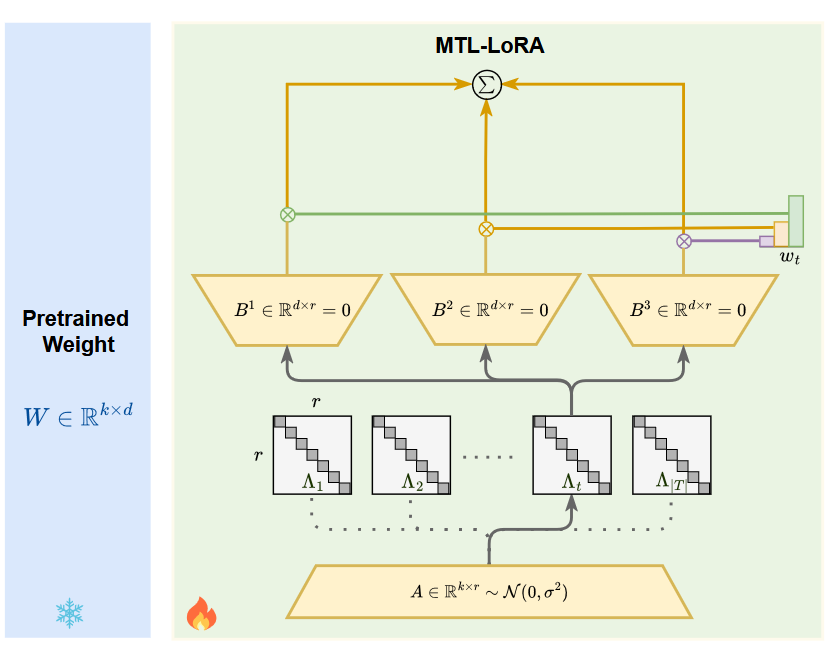


This formula allows the model to adjust its weights for each task, ensuring that the right parameters are focused on during task-specific training.

---

In [ ]:
# --- Task-Specific Weights Module ---
class MTLWeights(nn.Module):
    def __init__(self, input_dim, output_dim, rank, num_tasks, num_projections=3, tau=0.5):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.rank = rank
        self.num_tasks = num_tasks
        # number of matrix B for each task
        self.num_projections = num_projections
        self.tau = tau

        # Shared low-rank matrix A
        self.A = nn.Parameter(torch.randn(input_dim, rank) * 0.02)

        # Task-specific projection matrices (B_i) and Lambda matrices
        self.B = nn.ModuleList([nn.ParameterList([nn.Parameter(torch.randn(output_dim, rank) * 0.02)
                                                  for _ in range(num_projections)]) for _ in range(num_tasks)])
        self.Lambda = nn.ParameterList([nn.Parameter(torch.eye(rank)) for _ in range(num_tasks)])

        # Adaptive weights for each task
        self.task_weights = nn.ParameterList([nn.Parameter(torch.randn(num_projections)) for _ in range(num_tasks)])

    def forward(self, x, task_id):
        batch_size, seq_len, vocab_size = x.shape
        low_rank_contrib = torch.zeros_like(x, device=x.device)

        for i in range(batch_size):
            tid = task_id[i].item()

            # Compute A * Lambda for the task
            A_Lambda = torch.matmul(self.A, self.Lambda[tid])  # (input_dim, rank)

            # Calculate normalized weights using softmax
            task_w = torch.softmax(self.task_weights[tid] / self.tau, dim=0)

            # Combine multiple projections using adaptive weights
            for j, B_i in enumerate(self.B[tid]):
                # Projection computation
                projection = torch.matmul(A_Lambda, B_i.T)  # (input_dim, vocab_size)

                # Reshape or slicing to ensure the correct dimensions
                projection = projection[:seq_len, :vocab_size]  # Slice to match dimensions
                if projection.size(1) < vocab_size:
                    # Padding to reach the vocab_size dimension
                    padding = torch.zeros(seq_len, vocab_size - projection.size(1), device=projection.device)
                    projection = torch.cat([projection, padding], dim=1)

                # Add weighted projection to low_rank_contrib
                low_rank_contrib[i] += task_w[j] * projection

        return low_rank_contrib


mtl_weights = MTLWeights(
    input_dim=input_dim,
    output_dim=output_dim,
    rank=rank,
    num_tasks=num_tasks,
    num_projections=num_projections,
    tau=tau
).to(DEVICE)


# **CustomLlamaModel Class**
 Custom Model Architecture: Integrating Multi-Task Learning

The **CustomLlamaModel** class integrates the original Llama model with the MTL mechanism to allow for multi-task learning. In this model, each layer of the Llama model applies task-specific adaptations through the **apply_mtl** method, which combines the output of the original layer with adaptive weights derived from the MTL mechanism.

### How It Works:
1. **Layer-wise MTL Adaptation**:
   - Each attention and feed-forward layer is adapted based on the specific task being processed.
   - The output of each layer is modified by the task-specific contributions, computed using the MTL Weights.

2. **Task-specific Projection**:
   - For each task, projections are made from the hidden states using the task-specific projection matrices \( B_i \), adjusted by the corresponding task weight \( w_i^t \).

3. **Combining Contributions**:
   - The projections are weighted and combined, allowing the model to attend to the task-specific information, improving its ability to handle multiple tasks effectively.

### Key Aspects:
- **Embedding**: The input tokens are processed through the shared embedding layer of the Llama model.
- **Task Adaptation**: Each layer applies MTL-specific adaptations by using the task weights, projections, and low-rank matrices.
- **Final Output**: The logits generated by the model are then used for prediction, ensuring that each task is addressed with the appropriate parameters.

This structure ensures that the model remains efficient and adaptable to different tasks while leveraging shared parameters.

---


In [ ]:
# --- Custom Model ---
class CustomLlamaModel(nn.Module):
    def __init__(self, llama_model, mtl_weights, num_tasks):
        super().__init__()
        self.llama_model = llama_model  # The base Llama model
        self.mtl_weights = mtl_weights  # Multi-task learning weights
        self.num_tasks = num_tasks  # Number of tasks

    def forward(self, input_ids, attention_mask=None, labels=None, task_id=None):
        hidden_states = self.llama_model.model.embed_tokens(input_ids)  # Embed the input tokens

        # Expand and convert attention_mask
        if attention_mask is not None:
            attention_mask = attention_mask[:, None, None, :]
            attention_mask = attention_mask.to(dtype=torch.float16)  # Convert to float16 for compatibility

        for layer in self.llama_model.model.layers:
            position_ids = torch.arange(0, input_ids.size(1), device=input_ids.device).unsqueeze(0)

            # Apply multi-task learning (MTL) adaptations for each layer
            query = self.apply_mtl(layer.self_attn.q_proj, hidden_states, task_id)
            key = self.apply_mtl(layer.self_attn.k_proj, hidden_states, task_id)
            value = self.apply_mtl(layer.self_attn.v_proj, hidden_states, task_id)

            # Attention mechanism (query, key, value)
            attention_output = layer.self_attn(
                hidden_states=hidden_states,
                query=query,
                key=key,
                value=value,
                attention_mask=attention_mask,
                position_ids=position_ids,
            )

            # Add attention output to hidden states
            hidden_states = attention_output[0] + hidden_states

            # Apply MTL to the feed-forward network (FFN)
            ffn_output = self.apply_mtl(layer.mlp, hidden_states, task_id)
            hidden_states = ffn_output + hidden_states

        logits = self.llama_model.lm_head(hidden_states)  # Get the output logits from the LM head
        return {"logits": logits}

    def apply_mtl(self, layer, hidden_states, task_id):
        """
        Apply task-specific adaptations to the layer using MTL weights.
        """
        # Standard layer transformation
        original_output = layer(hidden_states)

        # Add task-specific adaptive contributions
        adaptive_contrib = self.mtl_weights(original_output, task_id)
        return original_output + adaptive_contrib

    def generate(self, *args, **kwargs):
        """
        Delegate generation to the base Llama model.
        """
        return self.llama_model.generate(*args, **kwargs)

# Initialize the custom model
custom_model = CustomLlamaModel(
    llama_model=model,  # Base Llama model
    mtl_weights=mtl_weights,  # Multi-task learning weights
    num_tasks=NUM_TASKS  # Number of tasks
).to(DEVICE)


**Train phase**
# Training the Custom Multi-Task Model

Training the **CustomLlamaModel** is done by iterating through the data using a standard training loop, but with task-specific updates applied at each step. The optimizer focuses on adjusting the weights of the MTL mechanism, and the model learns to address each task with the correct task-specific adaptations.

### Training Process:
1. **Data Preparation**:
   - The dataset is prepared using the `MultiTaskDataset`, which contains samples from all tasks. Each sample has an associated **task_id** that tells the model which task it is processing.

2. **Batching**:
   - The custom `collate_fn` is used to batch data and provide the model with task-specific inputs and labels.

3. **Forward Pass**:
   - For each batch, the model performs a forward pass, computing the logits for each task, applying the appropriate MTL adaptations at each layer.

4. **Loss Calculation**:
   - The loss is computed using the standard cross-entropy loss function, but the logits and labels are adjusted based on the task at hand.

5. **Weight Updates**:
   - The weights of the MTL mechanism are updated using the AdamW optimizer, and gradient scaling is used to ensure stable training with mixed precision.

6. **Scheduler**:
   - A learning rate scheduler is used to adjust the learning rate during training, helping the model converge more effectively.

### Formula for Loss Computation:
The loss is computed based on the predicted logits and the ground-truth labels for each task. For each batch, we use:

$$
\text{Loss} = \text{CrossEntropyLoss}(\text{shift_logits}, \text{shift_labels})
$$

Where the **shifted logits** represent the model’s predicted outputs, and the **shifted labels** are the corresponding target values, excluding the padding token.

In [ ]:
# --- Optimizer and Scheduler ---
optimizer = torch.optim.AdamW(mtl_weights.parameters(), lr=LEARNING_RATE)
scaler = torch.amp.GradScaler()  # For mixed precision training
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_dataloader) * EPOCHS)

# --- Training Function ---
def train_model(model, dataloader, optimizer, scheduler, epochs, device):
    model.train()  # Set the model to training mode
    loss_fct = CrossEntropyLoss()  # Define the loss function
    for epoch in range(epochs):
        total_loss = 0  # Initialize the total loss
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)  # Create a progress bar
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            task_id = batch['task_id'].to(device)

            optimizer.zero_grad()  # Clear previous gradients
            with torch.cuda.amp.autocast(dtype=torch.float16):  # Use automatic mixed precision for faster training
                outputs = model(input_ids, attention_mask=attention_mask, labels=None, task_id=task_id)
                # Shift logits and labels for next token prediction
                shift_logits = outputs["logits"][..., :-1, :].contiguous()
                shift_labels = labels[..., 1:].contiguous()
                loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))  # Calculate loss

            scaler.scale(loss).backward()  # Scale gradients for mixed precision
            scaler.step(optimizer)  # Update optimizer
            scaler.update()  # Update the scaler
            scheduler.step()  # Update learning rate

            total_loss += loss.item()  # Accumulate the total loss
            progress_bar.set_postfix({"Loss": f"{total_loss / (progress_bar.n + 1):.4f}"})  # Display loss in progress bar
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")


**Training**
Separato dalla dichiarazione delle classi al fine di poter eseguire la dichiarazione  delle classi senza dover far training

In [ ]:
# --- Training ---
train_model(custom_model, train_dataloader, optimizer, scheduler, EPOCHS, DEVICE)

**Saving Model with torch**

In [ ]:
# Path to save the model
save_path = "/content/drive/Shareddrives/Consegna_Progetti_MIRCV/LLM/Project/Models/mtl-lora_pubmeda_model"

# Make sure the path exists
os.makedirs(save_path, exist_ok=True)

# Save the state_dict
torch.save(custom_model.state_dict(), os.path.join(save_path, "custom_model_state_dict.pth"))

# Save the complete model (optional)
torch.save(custom_model, os.path.join(save_path, "custom_model_complete.pth"))


**Loading model**

In [ ]:
# Path to load the model
load_path = "/content/drive/Shareddrives/Consegna_Progetti_MIRCV/LM/Models/mtl-lora_pubmeda_model"

# Loading the state_dict
custom_model = CustomLlamaModel(
    llama_model=model,  # Base model
    mtl_weights=mtl_weights,  # Task-specific weights module
    num_tasks=NUM_TASKS
).to(DEVICE)

custom_model.load_state_dict(torch.load(os.path.join(load_path, "custom_model_state_dict.pth"), map_location=DEVICE))
custom_model.eval()  # Set the model to evaluation mode

# Loading the complete model
custom_model = torch.load(os.path.join(load_path, "custom_model_complete.pth"), map_location=DEVICE)
custom_model.eval()


<ipython-input-10-589200701715>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_model.load_state_dict(torch.load(os.path.join(load_path, "custom_model_state_dict.pt

CustomLlamaModel(
  (llama_model): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(128256, 2048)
      (layers): ModuleList(
        (0-15): 16 x LlamaDecoderLayer(
          (self_attn): LlamaSdpaAttention(
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (k_proj): Linear(in_features=2048, out_features=512, bias=False)
            (v_proj): Linear(in_features=2048, out_features=512, bias=False)
            (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (rotary_emb): LlamaRotaryEmbedding()
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
            (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
            (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
          (post_attenti

# **MTL-LoRA ChatBot**

In [ ]:

# Dictionary of models
models = {
    "custom": custom_model, # having only one model
}

# Model
current_model = models["custom"]

# Response generation function
def generate_response(prompt, task_id=0, max_length=128):
    """
    Generates a response given a prompt and a task_id.
    """
    # Tokenize the input
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=512).to(DEVICE)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"].to(dtype=torch.float, device=DEVICE)

    # Generate the response
    with torch.no_grad():
        logits = current_model.generate(
            input_ids=input_ids,
            max_length=max_length,
            num_return_sequences=1,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7,
            no_repeat_ngram_size=2,
            attention_mask=attention_mask,
            pad_token_id=tokenizer.pad_token_id
        )
        response = tokenizer.decode(logits[0], skip_special_tokens=True)
    return response

# Interactive loop for the chatbot
print("MTL-LoRA Chatbot ready! Type 'exit' to quit")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'exit':
        print("Chatbot: Goodbye!")
        break
    else:
        response = generate_response(user_input, task_id=0)  # Change the task_id if necessary
        print(f"Chatbot: {response}")


MTL-LoRA Chatbot ready! Type 'exit' to quit
You: Task: Solve the riddle. Riddle: {A man is incarcerated in prison, and as his punishment he has to carry a one tonne bag of sand backwards and forwards across a field the size of a football pitch.  What is the one thing he can put in it to make it lighter?} Choices: {["throw", "bit", "gallow", "mouse", "hole"]}
Chatbot: Task: Solve the riddle. Riddle: {A man is incarcerated in prison, and as his punishment he has to carry a one tonne bag of sand backwards and forwards across a field the size of a football pitch.  What is the one thing he can put in it to make it lighter?} Choices: {["throw", "bit", "gallow", "mouse", "hole"]} Answer: [["bit"]]
You: what is diabetes?
Chatbot: what is diabetes? what causes diabetes?
Diabetes is a disease which affects the body’s ability to control blood glucose or blood sugar level. The body is unable to regulate the level of blood sugars and they start to accumulate in the blood. This is called hyperglycem



```
MTL-LoRA Chatbot ready! Type 'exit' to quit

You: Task: Solve the riddle. Riddle: {A man is incarcerated in prison, and as his punishment he has to carry a one tonne bag of sand backwards and forwards across a field the size of a football pitch.  What is the one thing he can put in it to make it lighter?} Choices: {["throw", "bit", "gallow", "mouse", "hole"]}

Chatbot: Task: Solve the riddle. Riddle: {A man is incarcerated in prison, and as his punishment he has to carry a one tonne bag of sand backwards and forwards across a field the size of a football pitch.  What is the one thing he can put in it to make it lighter?} Choices: {["throw", "bit", "gallow", "mouse", "hole"]} Answer: [["bit"]]

You: what is diabetes?

Chatbot: what is diabetes? what causes diabetes?
Diabetes is a disease which affects the body’s ability to control blood glucose or blood sugar level. The body is unable to regulate the level of blood sugars and they start to accumulate in the blood. This is called hyperglycemia. Hyperglycaemia can cause damage to the heart, blood vessels, eyes, kidneys and nerves. In severe cases, diabetes can even lead to blindness, kidney failure and amputation.
Diabetics have to take insulin to keep the glucose level in their blood normal. Insulin is made by the pancreas and the amount of insulin produced by pancreases

You: exit

Chatbot: Goodbye!
```

